<a href="https://colab.research.google.com/github/br1anl1n/CooC-HeadBand-Preorder-Website/blob/main/Accuracy_Analyses_Overview_(AH_copy).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Accuracy Test Analyses Overview

This interactive python notebook is intended as a tool to facilitate accuracy test data analysis

**Requirements:**


*   Upload *CMMPointsT.csv* file
* Must run the following sections to complete any analyses: "Functions for data import and analysis" and "Define transformations between Optitrack and Zeta spaces"

**Analyses:**


1.   Static, single-point position error
2.   Static, multi-point position error
3.   Static position and trajectory angle error
4.   Navigation frequency
5.   Dynamic testing (front-to-back and side-to-side)





### Functions for data import and analysis
**Instructions**: Run these cells


In [ ]:
import numpy as np
from numpy import inf
import math
from numpy.linalg import inv
from scipy.spatial.transform import Rotation as R
from scipy.interpolate import interp1d
from scipy import signal, correlate, interpolate
import scipy.stats as stats
import torch
import io
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
from matplotlib.lines import Line2D
import seaborn as sns

In [ ]:
!pip install numpy.quaternion
!pip install pyquaternion
import pyquaternion as pyq
from pyquaternion import Quaternion
import quaternion

In [ ]:
def time_to_x(s):
    """
    This function converts the Zeta-output time-stamp, a string,
    into a float value (in seconds)
    Parameters\
    ----------
    s (str) : Time-stamp out-put by Zeta, e.g. '14:51:50.560'

    Returns
    -------
    x (float) : The time-stamp, s, converted to seconds, e.g. 53510.56

    """
    hr = s[0:2]
    mm = s[3:5]
    ss = s[6:]
    x = (float(hr)*3600) + (float(mm)*60) + (float(ss))
    return x

def zeta_times(file_Zeta):
    """
    This function reads the Zeta-output text file and returns a list of Zeta
    time-stamps (seconds)

    Parameters
    ----------
    file_Zeta (str) : Name of Zeta text file

    Returns
    -------
    zeta_time (list): Time values (type- float; units- seconds) for each snapshot
        in file_Zeta
    """
    with open(file_Zeta, 'r') as file:
        zdata = file.readlines()
    zeta_time = []
    zeta_orig_time = []
    for i in range(len(zdata)):
      if zdata[i][0:4] == "Test":
        t = zdata[i].split(" ")
        timestamp = time_to_x(t[-1])
        zeta_time.append(timestamp)
        zeta_orig_time.append(t[-1])
    return zeta_time

def open_Zeta(file_Zeta):
    """
    This function reads the Zeta-output text file and returns data of interest
    (e.g. toolWrtCt, ctWrtcam, ctWrtHead) for all snapshots collected in the file

    Parameters
    ----------
    file_Zeta (str) : Name of Zeta text file

    Returns
    -------
    toolWrtCt (list): List of transformation matrices (type- array; units- meters)
        decribing toolWrtCt for each snapshot in file_Zeta
    toolWrtCam (list): List of transformation matrices (type- array; units- meters)
        decribing toolWrtCam for each snapshot in file_Zeta
    ctWrtCam (list): List of transformation matrices (type- array; units- meters)
        decribing ctWrtCam for each snapshot in file_Zeta
        matrix out-put by Zeta describing ctWrtCam
    zeta_time (list): Time values (type- float; units- seconds) for each snapshot
        in file_Zeta
    zeta_sre (list): SRE values (type- float; units- millimeters) out put by Zeta
        for each snapshot in file_Zeta
    toolWrtCt_xyz (list):  List of translation arrays (type- array; units- meters)
        decribing the toolWrtCt position for each snapshot in file_Zeta
    """
    with open(file_Zeta, 'r') as file:
        zdata = file.readlines()
    toolWrtCt,toolWrtCam,ctWrtCam = [],[],[]
    zeta_time,zeta_orig_time = [],[]
    toolWrtCt_xyz = []
    zeta_sre = []
    for i in range(len(zdata)):
      if zdata[i][0:4] == "Test":
        t = zdata[i].split(" ")
        toolWrtCt_r1 = zdata[i+2].split(" ")
        toolWrtCt_r2 = zdata[i+3].split(" ")
        toolWrtCt_r3 = zdata[i+4].split(" ")
        toolWrtCt_r4 = zdata[i+5].split(" ")
        toolWrtCam_r1 = zdata[i+7].split(" ")
        toolWrtCam_r2 = zdata[i+8].split(" ")
        toolWrtCam_r3 = zdata[i+9].split(" ")
        toolWrtCam_r4 = zdata[i+10].split(" ")
        ctWrtCam_r1 = zdata[i+12].split(" ")
        ctWrtCam_r2 = zdata[i+13].split(" ")
        ctWrtCam_r3 = zdata[i+14].split(" ")
        ctWrtCam_r4 = zdata[i+15].split(" ")
        sre = zdata[i+16].split(" ")
        toolWrtCt_arr, toolWrtCt_arr1, toolWrtCt_arr2,toolWrtCt_arr3 = [], [], [], []
        toolWrtCam_arr, toolWrtCam_arr1, toolWrtCam_arr2,toolWrtCam_arr3 = [], [], [], []
        ctWrtCam_arr, ctWrtCam_arr1, ctWrtCam_arr2,ctWrtCam_arr3 = [], [], [], []
        for i in toolWrtCt_r1:
          if(i == ''):
            continue
          else:
            toolWrtCt_arr.append(float(i))
        for i in toolWrtCt_r2:
          if(i == ''):
            continue
          else:
            toolWrtCt_arr1.append(float(i))
        for i in toolWrtCt_r3:
          if(i == ''):
            continue
          else:
            toolWrtCt_arr2.append(float(i))
        for i in toolWrtCt_r4:
          if(i == ''):
            continue
          elif(i == '-nan(ind)\n'):
            toolWrtCt_arr3.append(float(1))
          else:
            toolWrtCt_arr3.append(float(i))
        for i in toolWrtCam_r1:
          if(i == ''):
            continue
          else:
            toolWrtCam_arr.append(float(i))
        for i in toolWrtCam_r2:
          if(i == ''):
            continue
          else:
            toolWrtCam_arr1.append(float(i))
        for i in toolWrtCam_r3:
          if(i == ''):
            continue
          else:
            toolWrtCam_arr2.append(float(i))
        for i in toolWrtCam_r4:
          if(i == ''):
            continue
          else:
            toolWrtCam_arr3.append(float(i))
        for i in ctWrtCam_r1:
          if(i == ''):
            continue
          else:
            ctWrtCam_arr.append(float(i))
        for i in ctWrtCam_r2:
          if(i == ''):
            continue
          else:
            ctWrtCam_arr1.append(float(i))
        for i in ctWrtCam_r3:
          if(i == ''):
            continue
          else:
            ctWrtCam_arr2.append(float(i))
        for i in ctWrtCam_r4:
          if(i == ''):
            continue
          else:
            ctWrtCam_arr3.append(float(i))
        # Ignore Zeta Snapshots where Navigation was paused (e.g. Instrument not in view)
        if toolWrtCt_arr == [1.0, 0.0, 0.0, 1.79769e+308] or toolWrtCt_arr[3] == float(-inf):
          continue
        toolWrtCt_x = toolWrtCt_arr[3]
        toolWrtCt_y = toolWrtCt_arr1[3]
        toolWrtCt_z = toolWrtCt_arr2[3]
        toolWrtCt_xyz.append(np.array([toolWrtCt_x, toolWrtCt_y, toolWrtCt_z]))
        toolWrtCt_mat = np.array([[toolWrtCt_arr, toolWrtCt_arr1, toolWrtCt_arr2, toolWrtCt_arr3]])
        toolWrtCt.append(toolWrtCt_mat)
        toolWrtCam_mat = np.array([[toolWrtCam_arr, toolWrtCam_arr1, toolWrtCam_arr2, toolWrtCam_arr3]])
        ctWrtCam_mat = np.array([[ctWrtCam_arr, ctWrtCam_arr1, ctWrtCam_arr2, ctWrtCam_arr3]])
        toolWrtCam.append(toolWrtCam_mat)
        ctWrtCam.append(ctWrtCam_mat)
        timestamp = time_to_x(t[-1])
        zeta_time.append(timestamp)
        zeta_orig_time.append(t[-1])
        zeta_sre.append(float(sre[1])*1000)
    return toolWrtCt, toolWrtCam, ctWrtCam, zeta_time, zeta_sre, toolWrtCt_xyz

def phantom_divots(file_CMM):
    """
    This function reads the CSV text file containing divot locations from the CMM scan,
    and returns a list of [x,y,z] arrays for each divot's known point position

    Parameters
    ----------
    file_CMM (str) : Name of CSV text file containing divot locations

    Returns
    -------
    CMM Points (list): list of [x,y,z] divot positions in numerical order (type- array; units- millimeters)
    """
    # Import known position of divot #11 (with respect to CT)
    CMMPointsDF = pd.read_csv('DivotPhantom02-Points.csv',header=None)
    CMMPoints = [] # List of [x,y,z] arrays for each divot's known point position
    row = 0
    while row < len(CMMPointsDF.index):
        CMMPoints.append(np.array([CMMPointsDF.iloc[row,1], CMMPointsDF.iloc[row,2],CMMPointsDF.iloc[row,3]]))
        row = row+1
    return CMMPoints

def trial_error(file_Zeta):
    """
    This function reads the Zeta-output text file and determines the
    instrument position error with respect to divot #11's position

    Parameters
    ----------
    file_Zeta (str) : Name of Zeta text file

    Returns
    -------
    trialError (list): List of position errors for each snapshot in the
        given Zeta file (type-float; units - millimeters)
   trialErrorMean (float): Mean position error across trialError values (units - millimeters)
   trialErrorStD (float): Standard deviation of position error across
       trialError values (units - millimeters)
   trialErrorCI (tuple): 99% confidence interval of position error across
       trialError values (units - millimeters)
   zeta_time (list): Time values (type- float; units- seconds) for each snapshot
           in file_Zeta
   """
    CMMPoints = phantom_divots('CMMPointsT.csv')
    divot11 = (CMMPoints[10])
    # Import Zeta static file
    toolWrtCt, toolWrtCam, ctWrtCam, zeta_time, zeta_sre, toolWrtCt_xyz = open_Zeta(file_Zeta)
    toolWrtCt_pos = []
    for m in range(len(toolWrtCt)):
      toolWrtCt_pos.append(np.array([toolWrtCt[m][0,0,3], toolWrtCt[m][0,1,3], toolWrtCt[m][0,2,3]]))
    # Compute position error (mm) for each snapshot
    trialError = []
    for t in range(len(toolWrtCt_pos)):
      trialError.append(np.linalg.norm((divot11-(toolWrtCt_pos[t]*1000))))
    trialErrorMean = np.mean(trialError)
    trialErrorStD = np.std(trialError)
    trialErrorCI = stats.norm.interval(0.99, loc=trialErrorMean, scale=trialErrorStD/math.sqrt(len(trialError)))
    return trialError, trialErrorMean, trialErrorStD, trialErrorCI, zeta_time

def open_Motive_phantom_static(file_Opti):
    """
    This function reads an Optitrack-output CSV file and returns information
    about the phantom's rotation and positon averaged over the entire Optitrack take.
    To use this function, the Optitrack CSV file must be exported according to
    the instructions in Confluence.

    Parameters
    ----------
    file_Opti (str): Name of Optitrack CSV file

    Returns
    -------
    qx_headWrtOpti (float): x-value of the [x,y,z,w] phantom quaternion averaged over the entire Optitrack take
    qy_headWrtOpti (float): y-value of the [x,y,z,w] phantom quaternion averaged over the entire Optitrack take
    qz_headWrtOpti (float): z-value of the [x,y,z,w] phantom quaternion averaged over the entire Optitrack take
    qw_headWrtOpti (float): w-value of the [x,y,z,w] phantom quaternion averaged over the entire Optitrack take
    x_headWrtOpti (float): x-value of the [x,y,z] phantom position averaged over the entire Optitrack take  (units - millimeters)
    y_headWrtOpti (float): y-value of the [x,y,z] phantom position averaged over the entire Optitrack take  (units - millimeters)
    z_headWrtOpti (float): z-value of the [x,y,z] phantom position averaged over the entire Optitrack take  (units - millimeters)
    """
    motive_df = pd.read_csv(file_Opti,header = None)
    qx_sum, qy_sum, qz_sum, qw_sum, x_sum, y_sum, z_sum, q_len = 0,0,0,0,0,0,0,0
    captureStartTime = motive_df.iloc[0,11].split(" ")
    if captureStartTime[1][0:2] == '12' and captureStartTime[2] == 'AM': # Converts Optitrack starting time stamp to UTC
      start_time = (time_to_x((motive_df.iloc[0,11].split(" "))[1])) - (12*3600)
    elif captureStartTime[2] == 'AM' or captureStartTime[1][0:2] == '12':
      start_time = (time_to_x((motive_df.iloc[0,11].split(" "))[1]))
    else:
      start_time = (12*3600) + time_to_x((motive_df.iloc[0,11].split(" "))[1])
    for row in (range(7,len(motive_df))):
        if math.isnan(float(motive_df.iloc[row,2])) == False:
          qxH, qyH, qzH, qwH, xH, yH, zH = motive_df.iloc[row,22], motive_df.iloc[row,23], motive_df.iloc[row,24], motive_df.iloc[row,25], motive_df.iloc[row,26], motive_df.iloc[row,27], motive_df.iloc[row,28]
          qx_sum += float(qxH)
          qy_sum += float(qyH)
          qz_sum += float(qzH)
          qw_sum += float(qwH)
          x_sum += float(xH)
          y_sum += float(yH)
          z_sum += float(zH)
          q_len += 1
    qx_headWrtOpti, qy_headWrtOpti, qz_headWrtOpti, qw_headWrtOpti = qx_sum/q_len, qy_sum/q_len, qz_sum/q_len, qw_sum/q_len
    x_headWrtOpti, y_headWrtOpti, z_headWrtOpti = x_sum/q_len, y_sum/q_len, z_sum/q_len
    return qx_headWrtOpti, qy_headWrtOpti, qz_headWrtOpti, qw_headWrtOpti,x_headWrtOpti,y_headWrtOpti,z_headWrtOpti

def open_Motive_instrument_static(file_Opti):
    """
    This function reads an Optitrack-output CSV file and returns information
    about the instrument's rotation and positon averaged over the entire Optitrack take.
    To use this function, the Optitrack CSV file must be exported according to
    the instructions in Confluence.

    Parameters
    ----------
    file_Opti (str): Name of Optitrack CSV file

    Returns
    -------
    qx_toolWrtOpti (float): x-value of the [x,y,z,w] instrument quaternion averaged over the entire Optitrack take
    qy_toolWrtOpti (float): y-value of the [x,y,z,w] instrument quaternion averaged over the entire Optitrack take
    qz_toolWrtOpti (float): z-value of the [x,y,z,w] instrument quaternion averaged over the entire Optitrack take
    qw_toolWrtOpti (float): w-value of the [x,y,z,w] instrument quaternion averaged over the entire Optitrack take
    x_toolWrtOpti (float): x-value of the [x,y,z] instrument position averaged over the entire Optitrack take  (units - millimeters)
    y_toolWrtOpti (float): y-value of the [x,y,z] instrument position averaged over the entire Optitrack take  (units - millimeters)
    z_toolWrtOpti (float): z-value of the [x,y,z] instrument position averaged over the entire Optitrack take  (units - millimeters)
    """
    motive_df = pd.read_csv(file_Opti,header = None)
    qx_sum, qy_sum, qz_sum, qw_sum, x_sum, y_sum, z_sum, q_len = 0,0,0,0,0,0,0,0
    captureStartTime = motive_df.iloc[0,11].split(" ")
    if captureStartTime[1][0:2] == '12' and captureStartTime[2] == 'AM': # Converts Optitrack starting time stamp to UTC
      start_time = (time_to_x((motive_df.iloc[0,11].split(" "))[1])) - (12*3600)
    elif captureStartTime[2] == 'AM' or captureStartTime[1][0:2] == '12':
      start_time = (time_to_x((motive_df.iloc[0,11].split(" "))[1]))
    else:
      start_time = (12*3600) + time_to_x((motive_df.iloc[0,11].split(" "))[1])
    for row in (range(7,len(motive_df))):
      if math.isnan(float(motive_df.iloc[row,26])) == False and math.isnan(float(motive_df.iloc[row,2])) == False: # Ignore Optitrack snpashots where instrument or head wasn't tracked
        qxB, qyB, qzB, qwB, xB, yB, zB = motive_df.iloc[row,2], motive_df.iloc[row,3], motive_df.iloc[row,4], motive_df.iloc[row,5], motive_df.iloc[row,6], motive_df.iloc[row,7], motive_df.iloc[row,8]
        qx_sum += float(qxB)
        qy_sum += float(qyB)
        qz_sum += float(qzB)
        qw_sum += float(qwB)
        x_sum += float(xB)
        y_sum += float(yB)
        z_sum += float(zB)
        q_len += 1
    qx_toolWrtOpti, qy_toolWrtOpti, qz_toolWrtOpti, qw_toolWrtOpti = qx_sum/q_len, qy_sum/q_len, qz_sum/q_len, qw_sum/q_len
    x_toolWrtOpti, y_toolWrtOpti, z_toolWrtOpti = x_sum/q_len, y_sum/q_len, z_sum/q_len
    return qx_toolWrtOpti, qy_toolWrtOpti, qz_toolWrtOpti, qw_toolWrtOpti, x_toolWrtOpti, y_toolWrtOpti, z_toolWrtOpti

def rigid_transform_3D(A, B):
    """
    This function computes the optimal rotation and translation between corresponding
    3D points. Source: http://nghiaho.com/?page_id=671
    Parameters
    ----------
    A and B: 3xN matrix of corresponding 3D points
    Returns
    ----------
    R: 3x3 rotation matrix
    t: 3x1 column vector
    """
    assert A.shape == B.shape
    num_rows, num_cols = A.shape
    if num_rows != 3:
        raise Exception(f"matrix A is not 3xN, it is {num_rows}x{num_cols}")
    num_rows, num_cols = B.shape
    if num_rows != 3:
        raise Exception(f"matrix B is not 3xN, it is {num_rows}x{num_cols}")
    # find mean column wise
    centroid_A = np.mean(A, axis=1)
    centroid_B = np.mean(B, axis=1)
    # ensure centroids are 3x1
    centroid_A = centroid_A.reshape(-1, 1)
    centroid_B = centroid_B.reshape(-1, 1)
    # subtract mean
    Am = A - centroid_A
    Bm = B - centroid_B
    H = Am @ np.transpose(Bm)
    # sanity check
    #if linalg.matrix_rank(H) < 3:
    #    raise ValueError("rank of H = {}, expecting 3".format(linalg.matrix_rank(H)))
    # find rotation
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    # special reflection case
    if np.linalg.det(R) < 0:
        print("det(R) < R, reflection detected!, correcting for it ...")
        Vt[2,:] *= -1
        R = Vt.T @ U.T
    t = -R @ centroid_A + centroid_B
    return R, t

def trial_angle_error(file_Zeta,file_Opti,headWrtCt,styletWrtProbe):
    """
    This function reads the Zeta-output text file and Optitrack-output csv file,
    and, given the appropriate transformation matrices from Optitrack to Zeta spaces,
    determines the instrument trajectory angle error.

    Parameters
    ----------
    file_Zeta (str) : Name of Zeta text file
    file_Opti (str) : Name of Optitrack csv file
    headWrtCt (array): Transformation matrix describing the optimal rotation and
        translation from the Optitrack phantom rigid body space to the Zeta CT space
    styletWrtProbe (array): Transformation matrix describing the optimal rotation and
        translation from the Optitrack instrument rigid body space to the Zeta instrument
        ROM file

    Returns
    -------
    angError (list): List of trajectory angle errors for each snapshot in the
        given Zeta file (type-float; units - millimeters)
   angErrorMean (float): Mean trajectory angle error across trialError values (units - millimeters)
   angErrorStD (float): Standard deviation of trajectory angle error across
       trialError values (units - millimeters)
   angErrorCI (tuple): 99% confidence interval of trajectory angle error across
       trialError values (units - millimeters)
   """
    # Import Zeta snapshots
    toolWrtCt, toolWrtCam, ctWrtCam, zeta_time, zeta_sre, toolWrtCt_xyz = open_Zeta(file_Zeta)
    # Import Optitrack take
    qx_toolWrtOpti, qy_toolWrtOpti, qz_toolWrtOpti, qw_toolWrtOpti, x_toolWrtOpti, y_toolWrtOpti, z_toolWrtOpti = open_Motive_instrument_static(file_Opti)
    qt = np.quaternion(qw_toolWrtOpti,qx_toolWrtOpti, qy_toolWrtOpti, qz_toolWrtOpti)
    qx_headWrtOpti, qy_headWrtOpti, qz_headWrtOpti, qw_headWrtOpti,x_headWrtOpti,y_headWrtOpti,z_headWrtOpti = open_Motive_phantom_static(file_Opti)
    print(qx_headWrtOpti, qz_headWrtOpti, qy_headWrtOpti)
    # qx_headWrtOpti, qy_headWrtOpti, qz_headWrtOpti, qw_headWrtOpti,x_headWrtOpti,y_headWrtOpti,z_headWrtOpti = -0.508681, -0.490431,0.490632, -0.509902, 126.282471, 193.33078,251.697266
    qt2 = np.quaternion(qw_headWrtOpti,qx_headWrtOpti, qy_headWrtOpti, qz_headWrtOpti)
    # Data from Optitrack
    # opti_x = x_toolWrtOpti
    # opti_y = y_toolWrtOpti
    # opti_z = z_toolWrtOpti
    # head_x, head_y, head_z = x_headWrtOpti,y_headWrtOpti,z_headWrtOpti
    if opti_df.iloc[2,2] == "Brainlab-Eng":
      opti_x, opti_y, opti_z = x_headWrtOpti,y_headWrtOpti,z_headWrtOpti
      head_x, head_y, head_z = x_toolWrtOpti, y_toolWrtOpti, z_toolWrtOpti
    else:
      head_x, head_y, head_z = x_headWrtOpti,y_headWrtOpti,z_headWrtOpti
      opti_x, opti_y, opti_z = x_toolWrtOpti, y_toolWrtOpti, z_toolWrtOpti

    # Rotations in x,y,z,w
    r_head = R.from_quat([qt2.x, qt2.y, qt2.z, qt2.w]).as_matrix()
    t_head = np.matrix([head_x, head_y, head_z]).transpose()/1000
    r_probe = R.from_quat([qt.x, qt.y, qt.z, qt.w]).as_matrix()
    t_probe = np.matrix([opti_x, opti_y, opti_z]).transpose()/1000
    headWrtOpti1 = np.vstack([np.hstack([r_head,t_head]),np.matrix([0,0,0,1])])
    probeWrtOpti1 = np.vstack([np.hstack([r_probe,t_probe]),np.matrix([0,0,0,1])])
    probeWrtHead_o = np.matmul(np.matmul(inv(headWrtOpti1), (probeWrtOpti1)), inv(styletWrtProbe))
    # Calculate trajectory angle error for each Zeta snapshot
    angError = []
    for i in range(len(toolWrtCt_xyz)):
        styletWrtCt = toolWrtCt[i]
        probeWrtHead_z = np.matmul(inv(headWrtCt), (styletWrtCt))
        errMat = np.array(np.matmul(inv(probeWrtHead_o), probeWrtHead_z))
        errMat1 = np.array([errMat[0][0:3],errMat[1][0:3], errMat[2][0:3]])
        prod_rm = R.from_matrix(errMat1)
        prod_q = prod_rm.as_quat()
        ang = 2* math.acos(prod_q[3])
        angError.append((math.degrees(ang)))

    angErrorMean = np.mean(angError)
    angErrorStD = np.std(angError)
    angErrorCI = stats.norm.interval(0.99, loc=angErrorMean, scale=angErrorStD/math.sqrt(len(angError)))
    return angError, angErrorMean, angErrorStD, angErrorCI

def open_Motive_dynamic(file_Opti):
    """
    This function reads an Optitrack-output CSV file and returns data of interest
    (e.g. toolWrtOpti, headWrtOpti) for all data pointa collected in the file

    Parameters
    ----------
    file_Opti (str): Name of Optitrack CSV file

    Returns
    -------
    toolWrtOpti (list): List of arrays describing the instrument rotation and position as
        [qx,qy,qz,qw,x,y,z] where qx,qy,qz,qw represents the instrument orientation
        as a quaternion and x,y,z represent the instrument position (units-millimeters)
    headWrtOpti (float): List of arrays describing the phantom rotation and position as
        [qx,qy,qz,qw,x,y,z] where qx,qy,qz,qw represents the phantom orientation
        as a quaternion and x,y,z represent the phantom position (units-millimeters)
    toolWrtOpti_xyz (list): list of [x,y,z] arrays describing the instrument position (units-millimeters)
    headWrtOpti_xyz (list): list of [x,y,z] arrays describing the phantom position (units-millimeters)
    opt_time (list): list of floats describing the time for each data point using a world clock (units- seconds)
    opt_orig_time (list): list of floats describing the time for each data point
        within in the Optitrack take, with the first time point starting at 0 (units- seconds)
    """
    motive_df = pd.read_csv(file_Opti,header = None)
    toolWrtOpti,headWrtOpti = [],[]
    toolWrtOpti_xyz,headWrtOpti_xyz = [],[]
    opt_time,opt_orig_time = [],[]
    captureStartTime = motive_df.iloc[0,11].split(" ")
    if captureStartTime[1][0:2] == '12' and captureStartTime[2] == 'AM': # Converts Optitrack starting time stamp to UTC
      start_time = (time_to_x((motive_df.iloc[0,11].split(" "))[1])) - (12*3600)
    elif captureStartTime[2] == 'AM' or captureStartTime[1][0:2] == '12':
      start_time = (time_to_x((motive_df.iloc[0,11].split(" "))[1]))
    else:
      start_time = (12*3600) + time_to_x((motive_df.iloc[0,11].split(" "))[1])
    for row in (range(7,len(motive_df))):
        if math.isnan(float(motive_df.iloc[row,26])) == False and math.isnan(float(motive_df.iloc[row,2])) == False: # Ignore Optitrack snpashots where instrument or head wasn't tracked
          qxB, qyB, qzB, qwB, xB, yB, zB = motive_df.iloc[row,2], motive_df.iloc[row,3], motive_df.iloc[row,4], motive_df.iloc[row,5], motive_df.iloc[row,6], motive_df.iloc[row,7], motive_df.iloc[row,8]
          tB = [float(qxB), float(qyB), float(qzB), float(qwB), float(xB), float(yB), float(zB)]
          toolWrtOpti.append(tB)
          toolWrtOpti_xyz.append(np.array([float(xB), float(yB), float(zB)]))
          qxH, qyH, qzH, qwH, xH, yH, zH = motive_df.iloc[row,22], motive_df.iloc[row,23], motive_df.iloc[row,24], motive_df.iloc[row,25], motive_df.iloc[row,26], motive_df.iloc[row,27], motive_df.iloc[row,28]
          tH = [float(qxH), float(qyH), float(qzH), float(qwH), float(xH), float(yH), float(zH)]
          headWrtOpti.append(tH)
          headWrtOpti_xyz.append(np.array([float(xH), float(yH), float(zH)]))
          opt_time.append(float(motive_df.iloc[row, 1])+start_time)
          opt_orig_time.append(float(motive_df.iloc[row, 1]))
    return toolWrtOpti, headWrtOpti, toolWrtOpti_xyz, headWrtOpti_xyz, opt_time, opt_orig_time

def divot_trial_error(file_Zeta,divot_n):
  """
    This function reads the Zeta-output text file and determines the
    instrument position error with respect to a given divot's position
    Parameters
    ----------
    file_Zeta (str) : Name of Zeta text file
    divot_n (int): Divot number

    Returns
    -------
    trialError (list): List of position errors for each snapshot in the
        given Zeta file (type-float; units - millimeters)
   trialErrorMean (float): Mean position error across trialError values (units - millimeters)
   trialErrorStD (float): Standard deviation of position error across
       trialError values (units - millimeters)
   trialErrorCI (tuple): 99% confidence interval of position error across
       trialError values (units - millimeters)
   """
  CMMPoints = phantom_divots('DivotPhantom02-Points.csv')
  divot = (CMMPoints[divot_n-1])
  # Import Zeta snapshots
  toolWrtCt, toolWrtCam, ctWrtCam, zeta_time, zeta_sre, toolWrtCt_xyz = open_Zeta(file_Zeta)  # Extract measured (x,y,z) position of tool tip (toolWrtCT)
  toolWrtCt_pos = []
  for m in range(0,20):
    toolWrtCt_pos.append(np.array([toolWrtCt[m][0,0,3], toolWrtCt[m][0,1,3], toolWrtCt[m][0,2,3]]))
  # Calculate positional error for each measurement
  trialError = [] #np.zeros((len(toolWrtCt_pos)))
  for t in range(len(toolWrtCt_pos)):
    trialError.append(np.linalg.norm((divot-(toolWrtCt_pos[t]*1000))))
  # Save outcome metrics
  trialErrorMean = np.mean(trialError)
  trialErrorStD = np.std(trialError)
  trialErrorCI = stats.norm.interval(0.99, loc=trialErrorMean, scale=trialErrorStD/math.sqrt(len(trialError)))
  return trialError, trialErrorMean, trialErrorStD, trialErrorCI

### Define transformations between Optitrack and Zeta spaces
**Instructions**: Modify the name for `opti_local_file`, an Optitrack take exported in local coordinates. Run cells

**IMPORTANT NOTE**: If the same rigid bodies are used on Motive for many tests, then you only need to export 1 local file to define the transformations between Optitrack and Zeta spaces. If rigid bodies are changed for different tests, you will have to repeat this definition for each test.

**IMPORTANT NOTE**: If position error is reported correctly, but trajectory angle error seems unexpectedly high, check that the head/ct and stylet/brainlab marker coordinates are correctly paired. For instance, `head_m1` (the position of marker 1 on the phantom, read as Marker 1 from `opti_local_file`) should be correctly paired with the corresponding marker on the CMM measurement, ct_m1 (which in this case is marker A)

In [ ]:
opti_local_file = 'neutral_local.csv'

In [ ]:
# Define the transformations between Optitrack and Zeta spaces
# Import Head and Stylet marker positions in Optitrack Local coordinates
opti_df = pd.read_csv(opti_local_file)
head_m1 = np.array([float(opti_df.iloc[7,10]),float(opti_df.iloc[7,11]),float(opti_df.iloc[7,12])])
head_m2 = np.array([float(opti_df.iloc[7,14]),float(opti_df.iloc[7,15]),float(opti_df.iloc[7,16])])
head_m3 = np.array([float(opti_df.iloc[7,18]),float(opti_df.iloc[7,19]),float(opti_df.iloc[7,20])])
head_m4 = np.array([float(opti_df.iloc[7,22]),float(opti_df.iloc[7,23]),float(opti_df.iloc[7,24])])
stylet_m1 = np.array([float(opti_df.iloc[7,34]),float(opti_df.iloc[7,35]),float(opti_df.iloc[7,36])])
stylet_m2 = np.array([float(opti_df.iloc[7,38]),float(opti_df.iloc[7,39]),float(opti_df.iloc[7,40])])
stylet_m3 = np.array([float(opti_df.iloc[7,42]),float(opti_df.iloc[7,43]),float(opti_df.iloc[7,44])])
# Corresponding Head markers in CMM space (Zeta labeled A-D)
ct_m1 = np.array([230.566,86.62782,30.73743]) # Marker A
ct_m2 = cmm_mB = np.array([231.0878,150.9126,30.9843]) # Marker B
ct_m4 = np.array([175.2906,151.1252,34.01558]) # Marker C
ct_m3 = np.array([170.0929,39.47244,42.68029]) # Marker D
# Corresponding Brainlab markers in ROM space (Zeta labeled A-C)
brainlab_m1 = np.array([1.50,0.00,171.00]) #A
brainlab_m2 = np.array([1.50,17.74,247.47]) #B
brainlab_m3 = np.array([1.50,-17.74,235.30]) #C
# Compute transformation matrix for the phantom, headWrtCt
head_A =  np.array([[head_m1[0],head_m2[0],head_m3[0],head_m4[0]],[head_m1[1],head_m2[1],head_m3[1],head_m4[1]],[head_m1[2],head_m2[2],head_m3[2],head_m4[2]]])
ct_B = np.array([[ct_m1[0],ct_m2[0],ct_m3[0],ct_m4[0]],[ct_m1[1],ct_m2[1],ct_m3[1],ct_m4[1]],[ct_m1[2],ct_m2[2],ct_m3[2],ct_m4[2]]])
headWrtCt_R, headWrtCt_t = rigid_transform_3D(head_A,ct_B)
headWrtCt = np.vstack([np.hstack([headWrtCt_R, headWrtCt_t]), np.mat([0,0,0,1])])
# Compute transformation matrix for the instrument, styletWrtProbe
stylet_A =  np.array([[stylet_m1[0],stylet_m2[0],stylet_m3[0]],[stylet_m1[1],stylet_m2[1],stylet_m3[1]],[stylet_m1[2],stylet_m2[2],stylet_m3[2]]])
brainlab_B =  np.array([[brainlab_m1[0],brainlab_m2[0],brainlab_m3[0]],[brainlab_m1[1],brainlab_m2[1],brainlab_m3[1]],[brainlab_m1[2],brainlab_m2[2],brainlab_m3[2]]])
styletWrtProbe_R, styletWrtProbe_t = rigid_transform_3D(stylet_A,brainlab_B)
styletWrtProbe = np.vstack([np.hstack([styletWrtProbe_R, styletWrtProbe_t]), np.mat([0,0,0,1])])

det(R) < R, reflection detected!, correcting for it ...


### 1. Static, single-point position error

Computes mean, standard deviation, and 99% CI of instrument position error(mm) to divot #11 for any Zeta static file.

**Instructions**:
1. Modify the variable `file_list` to match the names of static files imported (e.g. if the file names are staticFile1 and staticFile3, set `file_list = [1,3]`)
2. Run section
3. Save plot and table results

,staticFile #,Mean error (mm),SD (mm),99% CI (mm)
0,1,1.740604,0.076621,0.032894


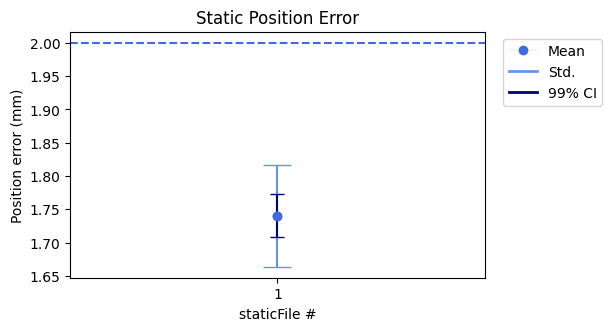

In [ ]:
# Initialize outcome metrics for each trial
posErrors = []
posErrorMeans = []
posErrorStDs = []
posErrorCIs = []
# Modify file list to match name of static files imported
file_list = [1]
for t in file_list:
    filename = f"staticFile2.txt"
    trialError, trialErrorMean, trialErrorStD, trialErrorCI, zeta_time = trial_error(filename)
    posErrors.append(trialError)
    posErrorMeans.append(trialErrorMean)
    posErrorStDs.append(trialErrorStD)
    posErrorCIs.append((trialErrorCI[1]-trialErrorCI[0])/2)
# Store results as plot
fig,ax = plt.subplots(figsize=(6,3.2),layout="constrained")
for i in range(len(file_list)):
  ax.errorbar(i,posErrorMeans[i],yerr = posErrorStDs[i],fmt='o', color = "royalblue",ecolor = "cornflowerblue",capsize=10, label = "Std.")
  ax.errorbar(i,posErrorMeans[i],yerr = posErrorCIs[i],fmt='o', color = "royalblue",ecolor = "navy",capsize=5, label = "99% CI")
ax.axhline(y = 2, linestyle = '--',color = 'royalblue')
ax.set_title("Static Position Error")
ax.set_xlabel("staticFile #")
ax.set_xticks(range(len(file_list)),file_list)
ax.set_ylabel("Position error (mm)")
custom_lines = [Line2D([], [], color="royalblue", marker = "o",lw=0.1),
                Line2D([0], [0], color="cornflowerblue", lw=2),
                Line2D([0], [0], color="navy", lw=2),]
plt.legend(custom_lines, ['Mean','Std.', '99% CI'],bbox_to_anchor=(1.3, 1.0),loc="upper right")
# Print results as table and save as CSV
static_error = {
    'staticFile #': file_list,
    'Mean error (mm)': posErrorMeans,
    'SD (mm)': posErrorStDs,
    '99% CI (mm)': posErrorCIs
    }
error_df = pd.DataFrame(static_error)
error_df.to_csv('static_error_results.csv', index=False)
display(error_df)

### 2. Static, multi-point position error

Computes mean, standard deviation, and 99% CI of instrument position error(mm) to any specified divot for any Zeta static file.

**Instructions**:
1. Modify the variable `staticFiles` to match the names of static files imported (e.g. if the file names are staticFile1 and staticFile3, set `file_list = [1,3]`)
2. Modify the variable `divot_list` to identify the divot at which error should be measured for each static file (in the corresponding order)
2. Run section
3. Save plot and table results

<ipython-input-10-e487377c80a6>:34: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


,Divot #,Mean error (mm),SD (mm),99% CI (mm)
0,11,3.258055,0.092530,0.053295
1,11,1.708285,0.063868,0.036786
2,11,4.471426,0.085247,0.049100
3,11,4.041214,0.065550,0.037755
4,11,5.751888,0.063069,0.036326
5,11,3.273879,0.082721,0.047645
6,11,2.546389,0.078150,0.045012
7,11,2.725261,0.064870,0.037363
8,11,3.917297,0.091183,0.052519
9,11,4.108223,0.083629,0.048168


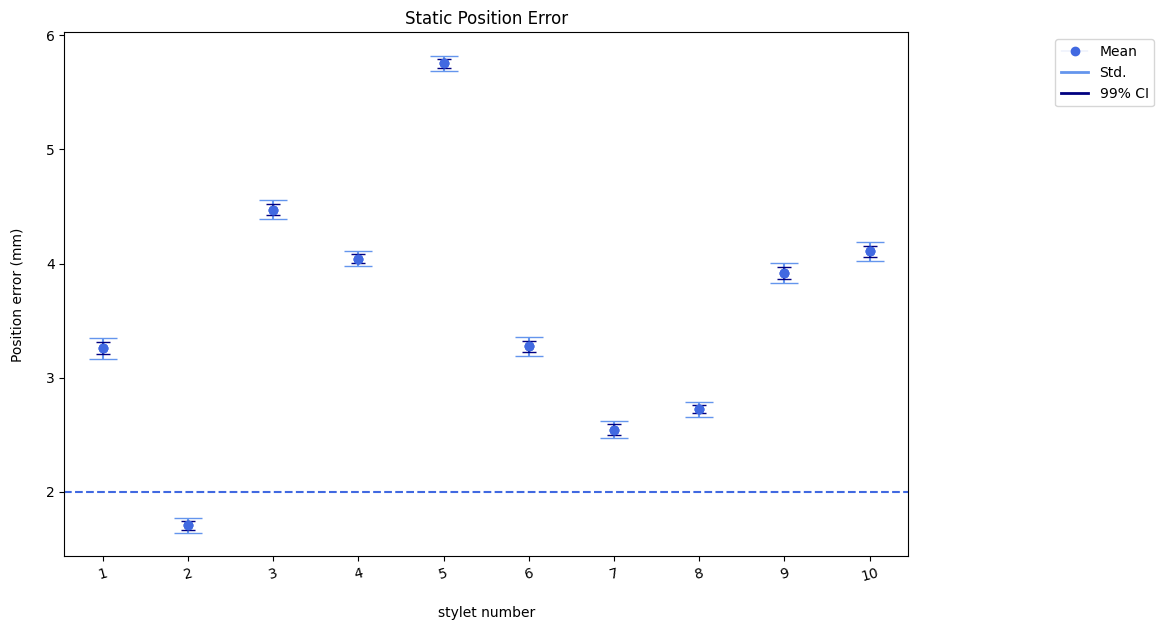

In [ ]:
# Store error and outcome metrics for each trial
divotErrors = []
divotErrorMeans = []
divotErrorStDs = []
divotErrorCIs = []
divot_list = [11,11,11,11,11,11,11,11,11,11] #Change this list to the list of divots you tested
staticFiles = range(1,11)
d_count = 0
for t in range(len(staticFiles)):
    filename = f"staticFile{staticFiles[t]}.txt"
    trialError, trialErrorMean, trialErrorStD, trialErrorCI = divot_trial_error(filename,divot_list[t])
    divotErrors.append(trialError)
    divotErrorMeans.append(trialErrorMean)
    divotErrorStDs.append(trialErrorStD)
    divotErrorCIs.append((trialErrorCI[1]-trialErrorCI[0])/2)
    d_count += 1
# Plot results
fig,ax = plt.subplots(figsize=(12,6.4),layout="constrained")
for i in range(len(divot_list)):
  ax.scatter(i,divotErrorMeans[i],color = "royalblue",label = "Mean TRE")
  ax.errorbar(i,divotErrorMeans[i],yerr = divotErrorStDs[i],fmt='o', color = "royalblue",ecolor = "cornflowerblue",capsize=10, label = "Std.")
  ax.errorbar(i,divotErrorMeans[i],yerr = divotErrorCIs[i],fmt='o', color = "royalblue",ecolor = "navy",capsize=5, label = "99% CI")
ax.axhline(y = 2, linestyle = '--',color = 'royalblue')
ax.set_title("Static Position Error")
ax.set_xlabel("\nstylet number")
divot_labels = [str(x) for x in staticFiles]
ax.set_xticks((range(len(staticFiles))),divot_labels,rotation=15,ha='center')
# ax.set_xticks(range(0,3),light_condition,rotation=80,ha='center')
ax.set_ylabel("Position error (mm)\n")
custom_lines = [Line2D([], [], color="royalblue", marker = "o",lw=0.1),
                Line2D([0], [0], color="cornflowerblue", lw=2),
                Line2D([0], [0], color="navy", lw=2),]
plt.legend(custom_lines, ['Mean','Std.', '99% CI'],bbox_to_anchor=(1.3, 1.0),loc="upper right")
fig.tight_layout()

# Display mean and standard deviation in table
# Create a DataFrame
divot_results = {
    'Divot #': divot_list,
    'Mean error (mm)': divotErrorMeans,
    'SD (mm)': divotErrorStDs,
    '99% CI (mm)': divotErrorCIs}
divot_results_df = pd.DataFrame(divot_results)
display(divot_results_df)

# Compute overall average and metrics
divotTRE_all = [item for sublist in divotErrors for item in sublist]
divotTREMean_all = np.mean(divotTRE_all)
divotTRETREStD_all = np.std(divotTRE_all)
divotTRETRECI_all= stats.norm.interval(0.99, loc=divotTREMean_all, scale=divotTRETREStD_all/math.sqrt(len(divotTRE_all)))

### 3. Static position and trajectory angle error

Computes mean, standard deviation, and 99% CI of instrument position error(mm) to divot #11 and trajectory angle error (for any Zeta static file.

**Instructions**:
1. Modify the variable `file_list` to match the names of static files imported (e.g. if the file names are staticFile1 and staticFile3, set `file_list = [1,3]`)
2. Run section
3. Save plot and table results

#### Compute position and trajectory angle error

129.12472469561428
129.11886460789898
129.1198916517512
129.14720655081064
129.11416139048958
129.09735313631487
129.08618760368202
129.07233355081325
129.1684703229421
129.13040242994828
129.14828331056748
129.17332536454575
129.05033191739992
129.08826593253275
129.12265374335578
129.18678356210768
129.1196234204693
129.13648044696302
129.13442112252454
129.1117890168768
129.14176983037032
129.1101858645788
129.16608248993566
129.12852716432417
129.08249584754466
129.12430188254154
129.10873225922592
129.063968725111
129.148768764604
129.1686783564368
129.13744447375007
129.18126804166053
129.1692797928048
129.1250745936039
129.158383150624
149.11621063246045
149.08636670744858
149.18183131975258
149.13172686343722
149.14502085817813
149.1534443465049
149.12293496910553
149.14744034499353
149.13528892581286
149.15997208922153
149.16787570458388
149.11320717538715
149.1661896982466
149.1600079076259
149.14411480159362
149.1955723131488
149.1719193624867
149.18495327266263
149.14647327

,staticFile,Mean position error (mm),SD (mm),99% CI (mm)
0,SR_neutral.txt,1.014616,0.037441,0.016301
1,SR_pitch.txt,0.765254,0.033840,0.015409
2,SR_pitch_roll.txt,0.790594,0.041691,0.018694
3,SR_pitch_roll_yaw.txt,0.850561,0.045882,0.021577


,staticFile,Mean angle error (°),SD (°),99% CI (°)
0,SR_neutral.txt,129.127615,0.033086,0.014405
1,SR_pitch.txt,149.149942,0.026172,0.011917
2,SR_pitch_roll.txt,194.597575,0.023112,0.010363
3,SR_pitch_roll_yaw.txt,142.804357,0.020036,0.009423


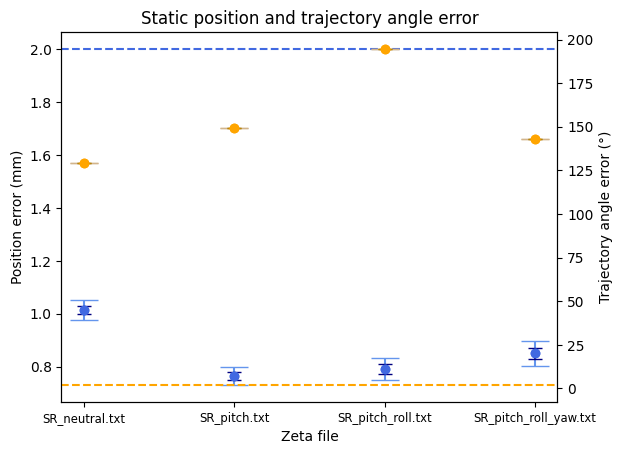

In [ ]:
# Compute position and angle error for the 4 data sets (neutral, max pitch, max pitch + roll, and max pitch, roll + yaw)
positionErrors,positionErrorMeans,positionErrorStDs,positionErrorCIs = [],[],[],[]
angleErrors,angleErrorMeans,angleErrorStDs,angleErrorCIs = [],[],[],[]
zeta_files = ['SR_neutral.txt','SR_pitch.txt','SR_pitch_roll.txt','SR_pitch_roll_yaw.txt']
opti_files = ['neutral.csv','pitch.csv','pitch_roll.csv','pitch_roll_yaw.csv']
for f in range(len(zeta_files)):
    trialError, trialErrorMean, trialErrorStD, trialErrorCI, zeta_time = trial_error(zeta_files[f])
    angError, angErrorMean, angErrorStD, angErrorCI = trial_angle_error(zeta_files[f],opti_files[f],headWrtCt,styletWrtProbe)
    positionErrors.append(trialError)
    positionErrorMeans.append(trialErrorMean)
    positionErrorStDs.append(trialErrorStD)
    positionErrorCIs.append((trialErrorCI[1]-trialErrorCI[0])/2)
    angleErrors.append(angError)
    angleErrorMeans.append(angErrorMean)
    angleErrorStDs.append(angErrorStD)
    angleErrorCIs.append((angErrorCI[1]-angErrorCI[0])/2)
# Plot results
fig,ax = plt.subplots()
ax2 = ax.twinx()
for i in range(len(positionErrorMeans)):
  ax.errorbar(i,positionErrorMeans[i],yerr = positionErrorStDs[i],fmt='o', color = "royalblue",ecolor = "cornflowerblue",capsize=10, label = "Std.")
  ax.errorbar(i,positionErrorMeans[i],yerr = positionErrorCIs[i],fmt='o', color = "royalblue",ecolor = "navy",capsize=5, label = "99% CI")
ax.axhline(y = 2, linestyle = '--',color = 'royalblue')
for i in range(len(angleErrorMeans)):
  ax2.errorbar(i,angleErrorMeans[i],yerr = angleErrorStDs[i],fmt='o', color = "orange",ecolor = "tan",capsize=10, label = "Std.")
  ax2.errorbar(i,angleErrorMeans[i],yerr = angleErrorCIs[i],fmt='o', color = "orange",ecolor = "darkgoldenrod",capsize=5, label = "99% CI")
ax2.axhline(y = 2, linestyle = '--',color = 'orange')
ax.set_title("Static position and trajectory angle error")
ax.set_xlabel("Zeta file")
ax.set_xticks(range(len(zeta_files)), zeta_files, size='small')
ax.set_ylabel("Position error (mm)")
ax2.set_ylabel("Trajectory angle error (°)")
# Print results as table and save as CSV
position_error = {
    'staticFile': zeta_files,
    'Mean position error (mm)': positionErrorMeans,
    'SD (mm)': positionErrorStDs,
    '99% CI (mm)': positionErrorCIs
    }
pos_error_df = pd.DataFrame(position_error)
display(pos_error_df)
angle_error = {
    'staticFile': zeta_files,
    'Mean angle error (°)': angleErrorMeans,
    'SD (°)': angleErrorStDs,
    '99% CI (°)': angleErrorCIs
    }
ang_error_df = pd.DataFrame(angle_error)
display(ang_error_df)

### 4. Navigation Frequency
Averages the period of snapshots obtained during a dynamic Zeta recording and then takes the reciprocal of this value to measure frequency.

**Instructions**:
1. Modify the variable `zeta_file` to match the name of the dynamic file imported
2. Run section
3. Save plot and table results

UNFILTERED

Mean: 16.353605105068205

Standard deviation: 0.4800098469715543

99% Confidence Interval: (16.314189365751204, 16.393020844385205)



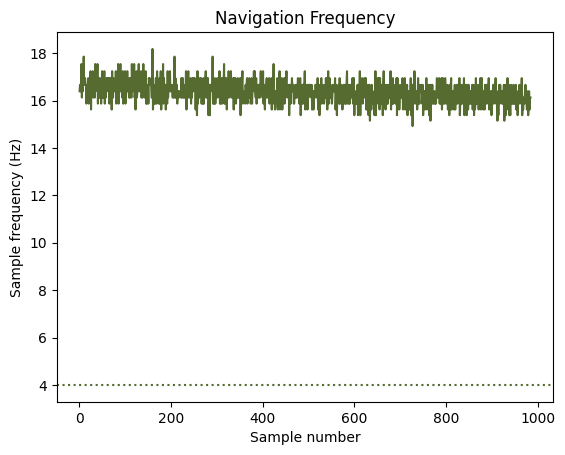

In [ ]:
zeta_file = "SR_nav_frequency NEW 1.txt"
# Compute navigation frequency between consecutive snapshots
zeta_time = zeta_times(zeta_file)
sample_n = list(range(len(zeta_time)))
frequency = []
for t in range(1,len(zeta_time)):
  frequency.append(1/(zeta_time[t]-zeta_time[t-1]))
# Store results as plot
fig, ax = plt.subplots()
ax.plot(sample_n[1:len(sample_n)],frequency,color="darkolivegreen")
ax.axhline(y = 4, linestyle = 'dotted',color="darkolivegreen")
ax.set_title("Navigation Frequency")
ax.set_xlabel("Sample number")
ax.set_ylabel("Sample frequency (Hz)")
# Store results as txt file
freq_mean = np.mean(frequency)
freq_std = np.std(frequency)
freq_99CI = stats.norm.interval(0.99, loc=freq_mean, scale=freq_std/math.sqrt(len(frequency)))
print(f"Mean: {freq_mean}\n")
print(f"Standard deviation: {freq_std}\n")
print(f"99% Confidence Interval: {freq_99CI}\n")

FILTERED

Mean: 20.18171557482283

Standard deviation: 1.9461532102315997

99% Confidence Interval: (20.035720836507455, 20.32771031313821)



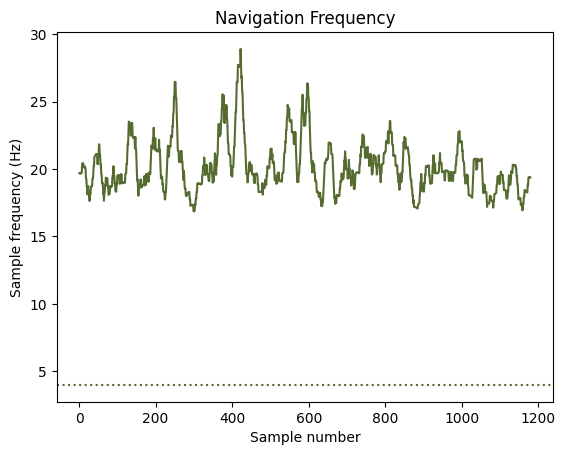

In [ ]:
zeta_file = "AR_nav_frequency.txt"
# Compute navigation frequency between consecutive snapshots
zeta_time = zeta_times(zeta_file)
zeta_time_f = np.convolve(zeta_time, np.ones(25)/25, mode='valid')
sample_n = list(range(len(zeta_time_f)))
frequency = []
for t in range(1,len(zeta_time_f)):
  frequency.append(1/(zeta_time_f[t]-zeta_time_f[t-1]))
# Store results as plot
fig, ax = plt.subplots()
ax.plot(sample_n[1:len(sample_n)],frequency,color="darkolivegreen")
ax.axhline(y = 4, linestyle = 'dotted',color="darkolivegreen")
ax.set_title("Navigation Frequency")
ax.set_xlabel("Sample number")
ax.set_ylabel("Sample frequency (Hz)")
# Store results as txt file
freq_mean = np.mean(frequency)
freq_std = np.std(frequency)
freq_99CI = stats.norm.interval(0.99, loc=freq_mean, scale=freq_std/math.sqrt(len(frequency)))
print(f"Mean: {freq_mean}\n")
print(f"Standard deviation: {freq_std}\n")
print(f"99% Confidence Interval: {freq_99CI}\n")

### 5. Dynamic testing
Computes mean, standard deviation, and 99% CI of instrument position error and trajectory angle error during movement.

**Instructions**:

1.  Modify the following variables to match the corresponding Zeta and  Optitrack files (ss: side-to-side, fb: front-to-back): `opti_local`, `zeta_ss`, `opti_ss`,`zeta_fb`, `opti_fb`
2. Run section ("Side-to-side movement" or "Front-to-back movement")
3. Review plots, adjust plot axes if needed, and save results

In [ ]:
opti_local = '120 Hz dynamic_local.csv'
zeta_ss = '120 Hz dynamic.txt'
opti_ss = '120 Hz dynamic.csv'
#zeta_fb = 'SR_dynamic_fb 2.txt'
#opti_fb = 'SR_dynamic_fb 2.csv'

#### Define transformations between Optitrack and Zeta spaces

In [ ]:
# Define the transformations between Optitrack and Zeta spaces
# Import Head and Stylet marker positions in Optitrack Local coordinates
opti_df = pd.read_csv(opti_local)
head_m1 = np.array([float(opti_df.iloc[7,30]),float(opti_df.iloc[7,31]),float(opti_df.iloc[7,32])])
head_m2 = np.array([float(opti_df.iloc[7,34]),float(opti_df.iloc[7,35]),float(opti_df.iloc[7,36])])
head_m3 = np.array([float(opti_df.iloc[7,38]),float(opti_df.iloc[7,39]),float(opti_df.iloc[7,40])])
head_m4 = np.array([float(opti_df.iloc[7,42]),float(opti_df.iloc[7,43]),float(opti_df.iloc[7,44])])
stylet_m1 = np.array([float(opti_df.iloc[7,10]),float(opti_df.iloc[7,11]),float(opti_df.iloc[7,12])])
stylet_m2 = np.array([float(opti_df.iloc[7,14]),float(opti_df.iloc[7,15]),float(opti_df.iloc[7,16])])
stylet_m3 = np.array([float(opti_df.iloc[7,18]),float(opti_df.iloc[7,19]),float(opti_df.iloc[7,20])])
# Corresponding Head markers in CMM space (Zeta labeled A-D)
ct_m1 = np.array([230.566,86.62782,30.73743]) # Marker A
ct_m2 = cmm_mB = np.array([231.0878,150.9126,30.9843]) # Marker B
ct_m3 = np.array([170.0929,39.47244,42.68029]) # Marker C
ct_m4 = np.array([175.2906,151.1252,34.01558]) # Marker D
# Corresponding Brainlab markers in ROM space (Zeta labeled A-C)
brainlab_m1 = np.array([1.50,0.00,171.00]) #A
brainlab_m2 = np.array([1.50,17.74,247.47]) #B
brainlab_m3 = np.array([1.50,-17.74,235.30]) #C
# Compute transformation matrix for the phantom, headWrtCt
head_A =  np.array([[head_m1[0],head_m2[0],head_m3[0],head_m4[0]],[head_m1[1],head_m2[1],head_m3[1],head_m4[1]],[head_m1[2],head_m2[2],head_m3[2],head_m4[2]]])
ct_B = np.array([[ct_m1[0],ct_m2[0],ct_m3[0],ct_m4[0]],[ct_m1[1],ct_m2[1],ct_m3[1],ct_m4[1]],[ct_m1[2],ct_m2[2],ct_m3[2],ct_m4[2]]])
headWrtCt_R, headWrtCt_t = rigid_transform_3D(head_A,ct_B)
headWrtCt = np.vstack([np.hstack([headWrtCt_R, headWrtCt_t]), np.mat([0,0,0,1])])
# Compute transformation matrix for the instrument, styletWrtProbe
stylet_A =  np.array([[stylet_m1[0],stylet_m2[0],stylet_m3[0]],[stylet_m1[1],stylet_m2[1],stylet_m3[1]],[stylet_m1[2],stylet_m2[2],stylet_m3[2]]])
brainlab_B =  np.array([[brainlab_m1[0],brainlab_m2[0],brainlab_m3[0]],[brainlab_m1[1],brainlab_m2[1],brainlab_m3[1]],[brainlab_m1[2],brainlab_m2[2],brainlab_m3[2]]])
styletWrtProbe_R, styletWrtProbe_t = rigid_transform_3D(stylet_A,brainlab_B)
styletWrtProbe = np.vstack([np.hstack([styletWrtProbe_R, styletWrtProbe_t]), np.mat([0,0,0,1])])

#### Side-to-side movement

##### Compute position and angle error over dynamic data sets

In [ ]:
# Compute position and angle error for the 4 data sets (neutral, max pitch, max pitch + roll, and max pitch, roll + yaw)
positionErrors,positionErrorMeans,positionErrorStDs,positionErrorCIs = [],[],[],[]
angleErrors,angleErrorMeans,angleErrorStDs,angleErrorCIs = [],[],[],[]
remove_t = 0
trialError, trialErrorMean, trialErrorStD, trialErrorCI, zeta_time = trial_error(zeta_ss)
angError, angErrorMean, angErrorStD, angErrorCI = trial_angle_error(zeta_ss,opti_ss,headWrtCt,styletWrtProbe)
positionErrors.append(trialError)
positionErrorMeans.append(trialErrorMean)
positionErrorStDs.append(trialErrorStD)
positionErrorCIs.append((trialErrorCI[1]-trialErrorCI[0])/2)
angleErrors.append(angError)
angleErrorMeans.append(angErrorMean)
angleErrorStDs.append(angErrorStD)
angleErrorCIs.append((angErrorCI[1]-angErrorCI[0])/2)


248.13904400473731 94.86990701546608 158.59550104868998


In [ ]:
import datetime
max_err = max(positionErrors[0])
print(max(positionErrors[0]))
max_indx = positionErrors[0].index(max_err)
max_time = zeta_time[max_indx]
convert = str(datetime.timedelta(seconds = 78911.435))
print(max_time)
print(convert)

2.709948575568823
52887.567
21:55:11.435000


##### Compute phantom linear speed and plot with error over time

In [ ]:
# Compute phantom linear speed measured by Optitrack
toolWrtCt, toolWrtCam, ctWrtCam, zeta_time, zeta_sre, toolWrtCt_xyz = open_Zeta(zeta_ss)
toolWrtOpti, headWrtOpti, toolWrtOpti_xyz, headWrtOpti_xyz, opt_time, opt_orig_time = open_Motive_dynamic(opti_ss)

In [ ]:
print(headWrtOpti_xyz)

[array([0.682662, 0.633967, 0.266535]), array([0.683263, 0.633183, 0.266406]), array([0.682735, 0.633882, 0.266513]), array([0.682981, 0.633535, 0.266448]), array([0.682622, 0.634022, 0.266533]), array([0.68265 , 0.633986, 0.266527]), array([0.683183, 0.633287, 0.266414]), array([0.683266, 0.633185, 0.266394]), array([0.683272, 0.63317 , 0.266397]), array([0.683235, 0.633216, 0.266413]), array([0.682693, 0.633938, 0.266519]), array([0.683344, 0.633072, 0.266395]), array([0.683355, 0.633057, 0.266393]), array([0.683243, 0.633203, 0.266414]), array([0.683188, 0.63326 , 0.266427]), array([0.683379, 0.633032, 0.266388]), array([0.683376, 0.633028, 0.266386]), array([0.683151, 0.633311, 0.26644 ]), array([0.683297, 0.633152, 0.266385]), array([0.68327 , 0.63317 , 0.266407]), array([0.683488, 0.632883, 0.266318]), array([0.683233, 0.633222, 0.266413]), array([0.683266, 0.633196, 0.266387]), array([0.683264, 0.633197, 0.266392]), array([0.682739, 0.633883, 0.266503]), array([0.683215, 0.63323

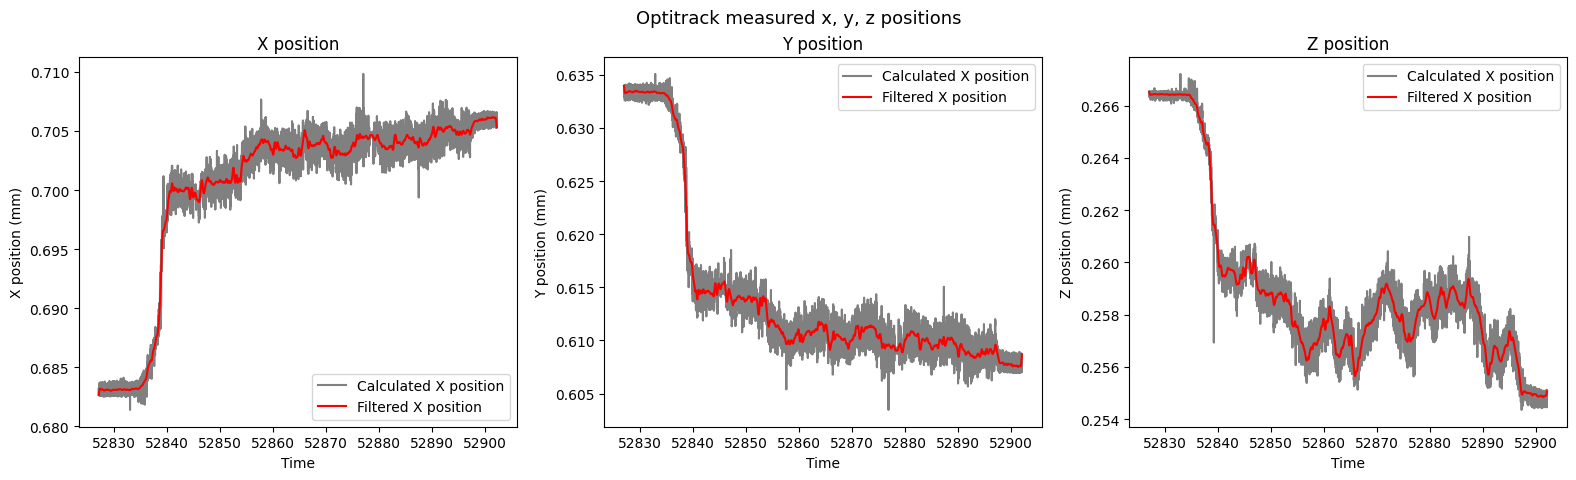

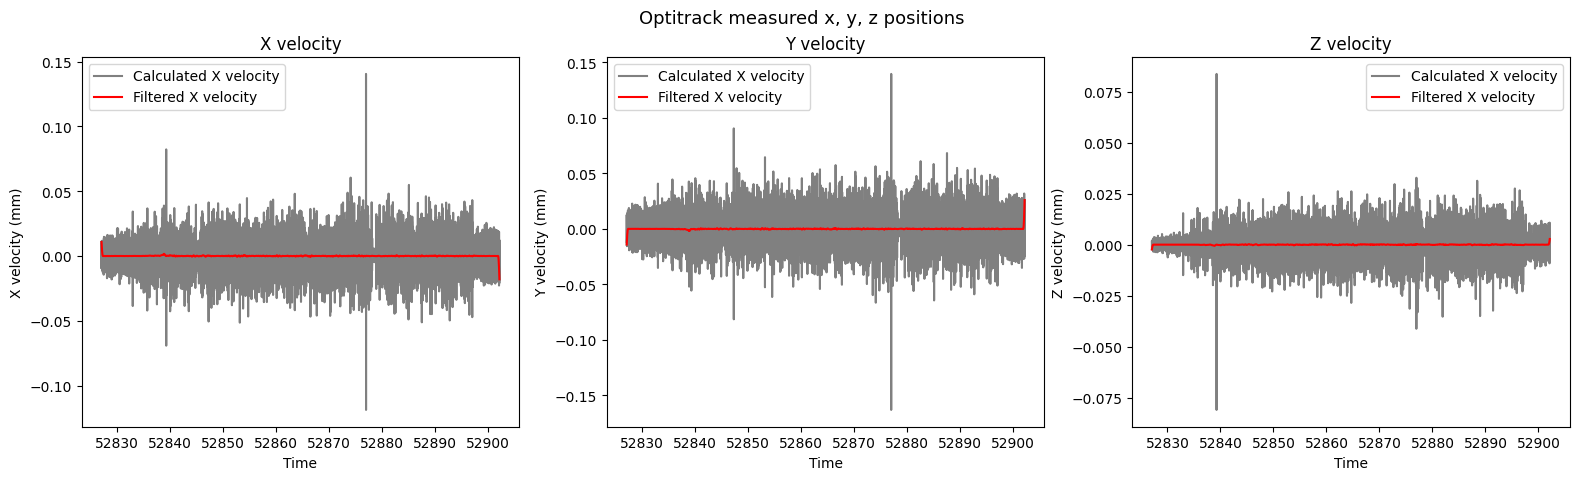

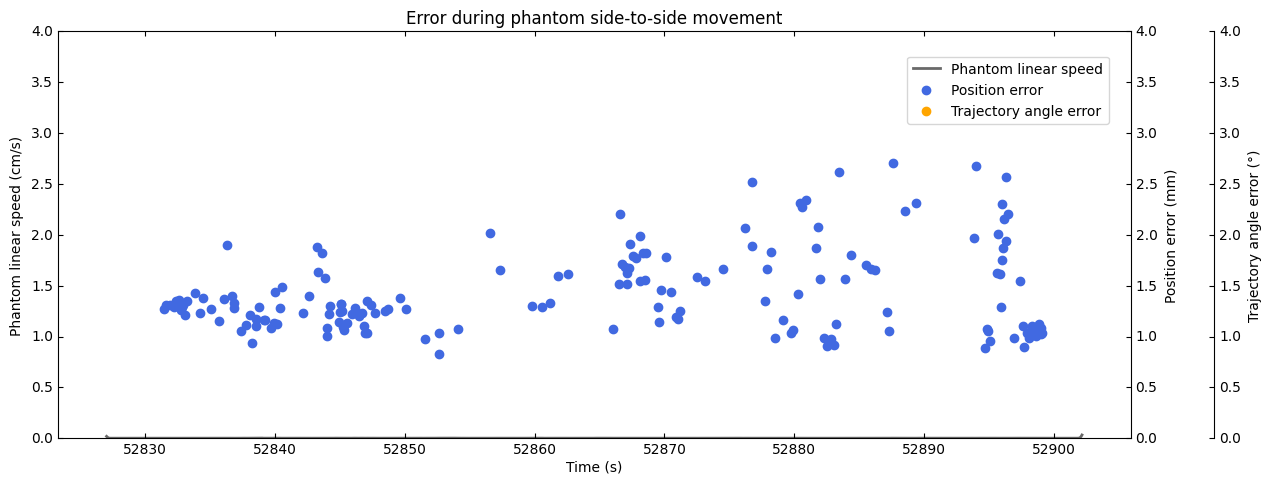

In [ ]:
# (1) Store Optirack measured x,y,z positions of the head
xPosOpti = []
yPosOpti = []
zPosOpti = []
for t in range(len(opt_time)):
  xPosOpti.append(headWrtOpti_xyz[t][0])
  yPosOpti.append(headWrtOpti_xyz[t][1])
  zPosOpti.append(headWrtOpti_xyz[t][2])
L= 45 #L-point filter; 45 points = 0.25 seconds
b = (np.ones(L))/L #numerator co-effs of filter transfer function
a = np.ones(1)  #denominator co-effs of filter transfer function
xPosOptiFiltered = signal.filtfilt(b,a,xPosOpti) #filter output using filtfilt function
yPosOptiFiltered = signal.filtfilt(b,a,yPosOpti)
zPosOptiFiltered = signal.filtfilt(b,a,zPosOpti)
# Plot calculted and filtered positions
fig,ax = plt.subplots(1,3,figsize=(19.2, 4.8))
fig.suptitle('Optitrack measured x, y, z positions',fontsize=13)
ax[0].plot(opt_time,xPosOpti, color = 'grey',label = "Calculated X position")
ax[0].plot(opt_time,xPosOptiFiltered, color = 'red',label = "Filtered X position")
ax[1].plot(opt_time,yPosOpti, color = 'grey',label = "Calculated X position")
ax[1].plot(opt_time,yPosOptiFiltered, color = 'red',label = "Filtered X position")
ax[2].plot(opt_time,zPosOpti, color = 'grey',label = "Calculated X position")
ax[2].plot(opt_time,zPosOptiFiltered, color = 'red',label = "Filtered X position")
ax[0].set(title = 'X position',xlabel = 'Time',ylabel='X position (mm)')
ax[0].legend()
ax[1].set(title = 'Y position',xlabel = 'Time',ylabel='Y position (mm)')
ax[1].legend()
ax[2].set(title = 'Z position',xlabel = 'Time',ylabel='Z position (mm)')
ax[2].legend()
# (2) Compute phantom linear speed given filtered position data
xVel, yVel, zVel = [],[],[]
for t in range(1,len(opt_time)):
  dt = opt_time[t]-opt_time[t-1]
  xVel.append((xPosOpti[t]-xPosOpti[t-1])/dt*1/10) # *1/10 converts to cm/s
  yVel.append((yPosOpti[t]-yPosOpti[t-1])/dt*1/10)
  zVel.append((zPosOpti[t]-zPosOpti[t-1])/dt*1/10)
xVelFiltered = signal.filtfilt(b,a,xVel) #filter output using filtfilt function
yVelFiltered = signal.filtfilt(b,a,yVel)
zVelFiltered = signal.filtfilt(b,a,zVel)
# Plot calculted and filtered velocities
fig,ax = plt.subplots(1,3,figsize=(19.2, 4.8))
fig.suptitle('Optitrack measured x, y, z positions',fontsize=13)
ax[0].plot(opt_time[1:],xVel, color = 'grey',label = "Calculated X velocity")
ax[0].plot(opt_time[1:],xVelFiltered, color = 'red',label = "Filtered X velocity")
ax[1].plot(opt_time[1:],yVel, color = 'grey',label = "Calculated X velocity")
ax[1].plot(opt_time[1:],yVelFiltered, color = 'red',label = "Filtered X velocity")
ax[2].plot(opt_time[1:],zVel, color = 'grey',label = "Calculated X velocity")
ax[2].plot(opt_time[1:],zVelFiltered, color = 'red',label = "Filtered X velocity")
ax[0].set(title = 'X velocity',xlabel = 'Time',ylabel='X velocity (mm)')
ax[0].legend()
ax[1].set(title = 'Y velocity',xlabel = 'Time',ylabel='Y velocity (mm)')
ax[1].legend()
ax[2].set(title = 'Z velocity',xlabel = 'Time',ylabel='Z velocity (mm)')
ax[2].legend()
# (3) Plot Zeta errors and phantom speed across time
headSpeedOptiFiltered = []
for t in range(len(xVelFiltered)):
  vel_norm = np.array([xVelFiltered[t],yVelFiltered[t],zVelFiltered[t]])
  headSpeedOptiFiltered.append(np.linalg.norm(vel_norm))
# Plot |Filtered linear velocity| vs Time; Position error vs Time; Trajectory angle error vs Time
fig = plt.figure(figsize=(12.4,4.8))
host = host_subplot(111, axes_class=axisartist.Axes)
par1 = host.twinx()
par2 = host.twinx()
par2.axis["right"] = par2.new_fixed_axis(loc="right", offset=(60, 0))
par1.axis["right"].toggle(all=True)
par2.axis["right"].toggle(all=True)
host.plot(opt_time[1:],headSpeedOptiFiltered,lw = 2,color="dimgray", label = "Phantom linear speed")
par1.scatter(zeta_time,positionErrors,color = "royalblue", label = "Position error")
par2.scatter(zeta_time,angleErrors,color = "orange", label = "Trajectory angle error")
host.set(ylim = (0,4),title = "Error during phantom side-to-side movement", xlabel="Time (s)", ylabel="Phantom linear speed (cm/s)")
par1.set(ylim=(0,4),ylabel = "Position error (mm)")
par2.set(ylim=(0,4),ylabel = "Trajectory angle error (°)")
lgd = fig.legend(bbox_to_anchor=(0.8,0.8), loc = "center",facecolor='white')
plt.tight_layout()

##### Compute phantom speed for each Zeta snapshot

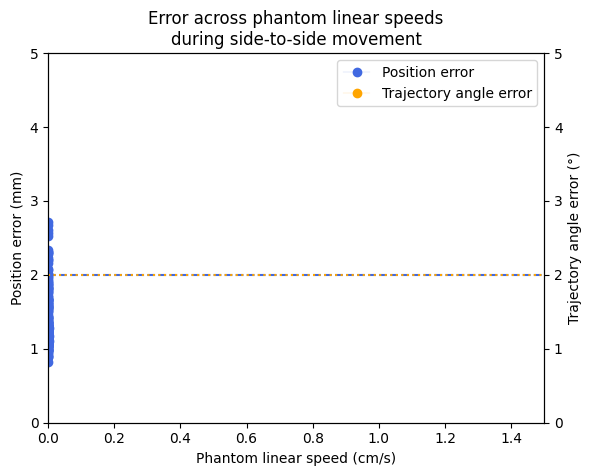

In [ ]:
# Compute phantom speed for each Zeta snapshot
# Calculate phantom velocity for every Zeta snapshot
f_interpolate = interp1d(opt_time[1:], headSpeedOptiFiltered)
zeta_vel = f_interpolate(zeta_time)
# Plot Position error and Trajectory angle error vs translational velocity
fig,ax = plt.subplots()
ax2 = ax.twinx()
ax.scatter(zeta_vel,positionErrors, color = "royalblue",label='Position error')
ax.axhline(y = 2, linestyle = '--',color='royalblue')
ax.set(title = "Error across phantom linear speeds\nduring side-to-side movement",ylim=(0,5),xlim=(0,1.5), xlabel="Phantom linear speed (cm/s)", ylabel="Position error (mm)")
# Plot Trajectory Angle error v. Time
ax2.scatter(zeta_vel,angleErrors, color = "orange",label='Trajectory angle error')
ax2.axhline(y = 2, linestyle = 'dotted',color = 'orange')
ax2.set(ylabel="Trajectory angle error (°)",ylim=(0,5))
err_markers = [Line2D([], [], color="royalblue", marker = "o",lw=0.1),
               Line2D([], [], color="orange", marker = "o",lw=0.1)]
lgd = ax2.legend(err_markers, ['Position error','Trajectory angle error'],bbox_to_anchor=(1.0, 1.0),loc="upper right")

##### Compute phantom speed for each Zeta snapshot

/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


,Velocity,Avg.,Std.,"99% CI, Lower bound","99% CI, Upper bound",Samples
11,0.000005,1.427980,0.406050,1.348689,1.507270,174
3,0.000006,1.427967,0.407222,1.348218,1.507716,173
13,0.000006,1.428744,0.408276,1.348556,1.508931,172
171,0.000006,1.429016,0.409453,1.348363,1.509669,171
66,0.000008,1.431020,0.409818,1.350058,1.511983,170
...,...,...,...,...,...,...
70,0.000926,1.166285,0.203099,0.932326,1.400245,5
32,0.001000,1.251286,0.124242,1.091273,1.411299,4
26,0.001263,1.189834,0.073999,1.079785,1.299882,3
25,0.001342,1.196850,0.089812,1.033268,1.360431,2


The max. velocity with min. 20 samples, is 0.0005873937748929331 
Index: 76
Max speed: 0


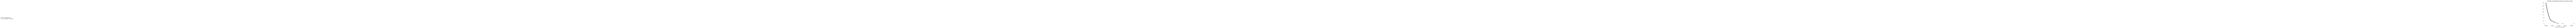

In [ ]:
# Compute average,std., and 99% CI of error for each velocity range [v, v+3.5 mm/s]
velocities = [abs(ele) for ele in zeta_vel]
posErrRange_avg,posErrRange_std,posErrRange_ci_L,posErrRange_ci_U = [],[],[],[]
n_samples = []
angErrRange_avg,angErrRange_std,angErrRange_ci_L,angErrRange_ci_U = [],[],[],[]
for v in velocities:
  v_posErrs = []
  v_angErrors = []
  count = 0
  for v2 in range(len(velocities)):
    if v <= velocities[v2] <= v + 0.35:
      v_posErrs.append(positionErrors[0][v2])
      v_angErrors.append(angleErrors[0][v2])
      count += 1
  posErrRange_avg.append(np.mean(v_posErrs))
  posErrRange_std.append(np.std(v_posErrs))
  ci_lower,ci_upper = stats.norm.interval(0.99, loc=np.mean(v_posErrs), scale=np.std(v_posErrs)/math.sqrt(len(v_posErrs)))
  posErrRange_ci_L.append(ci_lower)
  posErrRange_ci_U.append(ci_upper)
  n_samples.append(count)
  angErrRange_avg.append(np.mean(v_angErrors))
  angErrRange_std.append(np.std(v_angErrors))
  ci_low_ang,ci_up_ang = stats.norm.interval(0.99, loc=np.mean(v_angErrors), scale=np.std(v_angErrors)/math.sqrt(len(v_angErrors)))
  angErrRange_ci_L.append(ci_low_ang)
  angErrRange_ci_U.append(ci_up_ang)
# Determine when the number of samples for each range is < 20 samples
pos_ranges = {'Velocity': velocities,'Avg.': posErrRange_avg,'Std.':posErrRange_std, '99% CI, Lower bound': posErrRange_ci_L,'99% CI, Upper bound': posErrRange_ci_U, 'Samples': n_samples}
df_pos_ranges = pd.DataFrame(pos_ranges)
df_pos_ranges = df_pos_ranges.sort_values(by=['Velocity'])
ang_ranges = {'Velocity': velocities,'Avg.': angErrRange_avg,'Std.':angErrRange_std, '99% CI, Lower bound': angErrRange_ci_L,'99% CI, Upper bound': angErrRange_ci_U, 'Samples': n_samples}
df_ang_ranges = pd.DataFrame(ang_ranges)
df_ang_ranges = df_ang_ranges.sort_values(by=['Velocity'])
for max_index, row in df_pos_ranges.iterrows():
    if row['Samples'] < 20:
        velocity_below_20 = row['Velocity']
        break

display(df_pos_ranges)

# Plot number of samples in each velocity range
fig,ax = plt.subplots()
ax.scatter(velocities, n_samples,color='grey')
plt.axhline(y=20,color='grey',linestyle='dotted')
ax.set(title = 'Number of snapshots within each velocity range',xlabel='|Linear velocity| (cm/s)',ylabel='Number of snapshots for velocity, v \nwithin range [v, v + 0.35cm/s]')
plt.text(velocity_below_20-0.2,40,f'The max. velocity with\nmin. 20 samples, is {velocity_below_20:.2f}cm/s')
print('The max. velocity with min. 20 samples, is',velocity_below_20,'\nIndex:',max_index)

# Plot position and angle error across phantom linear velocities
# Determine maximum speed, where upper bound of 99% CI on position error crosses 2mm threshold
sorted_vel =  list(df_pos_ranges['Velocity'])
sorted_pos_avg = list(df_pos_ranges['Avg.'])
sorted_pos_std = list(df_pos_ranges['Std.'])
sorted_pos_ciL = list(df_pos_ranges['99% CI, Lower bound'])
sorted_pos_ciU = list(df_pos_ranges['99% CI, Upper bound'])
sorted_pos_stdL = [avg_error - std_dev for avg_error, std_dev in zip(sorted_pos_avg, sorted_pos_std)]
sorted_pos_stdU = [avg_error + std_dev for avg_error, std_dev in zip(sorted_pos_avg, sorted_pos_std)]
sorted_ang_avg = list(df_ang_ranges['Avg.'])
sorted_ang_std = list(df_ang_ranges['Std.'])
sorted_ang_ciL = list(df_ang_ranges['99% CI, Lower bound'])
sorted_ang_ciU = list(df_ang_ranges['99% CI, Upper bound'])
sorted_ang_stdL = [avg_error - std_dev for avg_error, std_dev in zip(sorted_ang_avg, sorted_ang_std)]
sorted_ang_stdU = [avg_error + std_dev for avg_error, std_dev in zip(sorted_ang_avg, sorted_ang_std)]
max_speed = 0
for e in range(len(sorted_pos_ciU)):
  if (sorted_pos_ciU[e]) >= 2:
    max_speed += sorted_vel[e]
    break
print('Max speed:',max_speed)

The maximum phantom linear speed (cm/s) is: 0


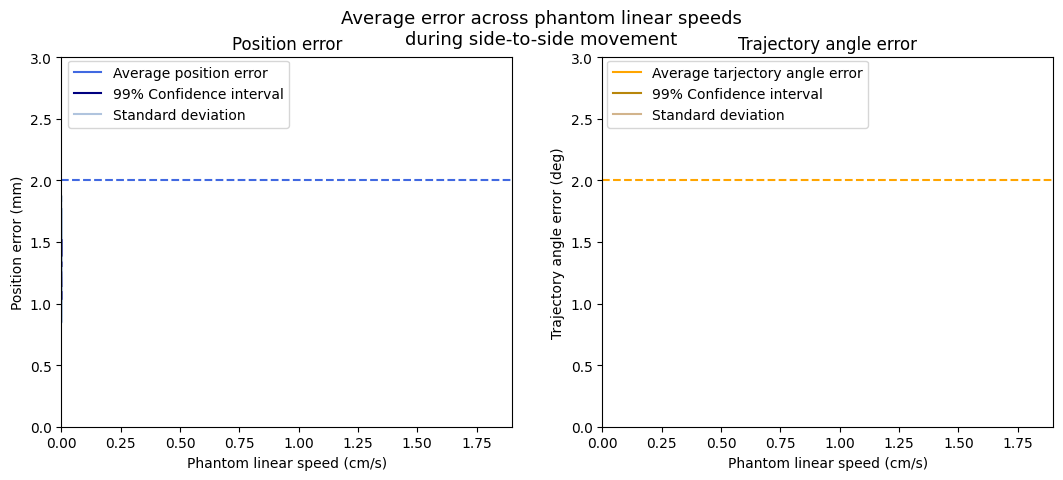

In [ ]:
# Plot results for position error
fig,ax = plt.subplots(1,2,figsize=(12.8, 4.8))
fig.suptitle('Average error across phantom linear speeds\nduring side-to-side movement',fontsize=13)
ax[0].plot(sorted_vel,sorted_pos_avg, color = 'royalblue',label = "Average position error")
ax[0].set(title = 'Position error',xlabel = 'Phantom linear speed (cm/s)',xlim = (0,1.9),ylabel='Position error (mm)',ylim = (0,3))
ax[0].axhline(y=2,linestyle = '--',color='royalblue')
ax[0].plot(sorted_vel,sorted_pos_ciL,color = 'navy',label = '99% Confidence interval')
ax[0].plot(sorted_vel,sorted_pos_ciU,color = 'navy')
ax[0].plot(sorted_vel,sorted_pos_stdL,color='lightsteelblue',label = 'Standard deviation')
ax[0].plot(sorted_vel,sorted_pos_stdU,color='lightsteelblue')
ax[0].legend(bbox_to_anchor=(0.26,0.9),loc="center")
ax[0].axvline(x=max_speed,linestyle = '--',color='navy',lw=1.4)
# Plot results for trajectory angle error
ax[1].plot(sorted_vel,sorted_ang_avg, color = 'orange',label = "Average tarjectory angle error")
ax[1].set(title = 'Trajectory angle error',xlabel = 'Phantom linear speed (cm/s)',xlim = (0,1.9),ylabel='Trajectory angle error (deg)',ylim = (0,3))
ax[1].axhline(y=2,linestyle = '--',color='orange')
ax[1].plot(sorted_vel,sorted_ang_ciL,color = 'darkgoldenrod',label = '99% Confidence interval')
ax[1].plot(sorted_vel,sorted_ang_ciU,color = 'darkgoldenrod')
ax[1].plot(sorted_vel,sorted_ang_stdL,color='tan',label = 'Standard deviation')
ax[1].plot(sorted_vel,sorted_ang_stdU,color='tan')
ax[1].legend(bbox_to_anchor=(0.3,0.9),loc="center")
ax[1].axvline(x=max_speed,linestyle = '--',color='navy',lw=1.4)

print("The maximum phantom linear speed (cm/s) is:",max_speed)

#### Front-to-back movement

##### Compute position and angle error over dynamic data sets

In [ ]:
# Compute position and angle error for the 4 data sets (neutral, max pitch, max pitch + roll, and max pitch, roll + yaw)
positionErrors,positionErrorMeans,positionErrorStDs,positionErrorCIs = [],[],[],[]
angleErrors,angleErrorMeans,angleErrorStDs,angleErrorCIs = [],[],[],[]
remove_t = 0
trialError, trialErrorMean, trialErrorStD, trialErrorCI, zeta_time = trial_error(zeta_fb)
angError, angErrorMean, angErrorStD, angErrorCI = trial_angle_error(zeta_fb,opti_fb,headWrtCt,styletWrtProbe)
positionErrors.append(trialError)
positionErrorMeans.append(trialErrorMean)
positionErrorStDs.append(trialErrorStD)
positionErrorCIs.append((trialErrorCI[1]-trialErrorCI[0])/2)
angleErrors.append(angError)
angleErrorMeans.append(angErrorMean)
angleErrorStDs.append(angErrorStD)
angleErrorCIs.append((angErrorCI[1]-angErrorCI[0])/2)

-0.3627261851293447 0.6072050019838148 -0.6004196662434538


In [ ]:
import datetime
max_err = max(positionErrors[0])
print(max(positionErrors[0]))
max_indx = positionErrors[0].index(max_err)
max_time = zeta_time[max_indx]
convert = str(datetime.timedelta(seconds = 78911.435))
print(max_time)
print(convert)

24.63998960883024
56026.439
21:55:11.435000


##### Compute phantom linear speed and plot with error over time

In [ ]:
# Compute phantom linear speed measured by Optitrack
toolWrtCt, toolWrtCam, ctWrtCam, zeta_time, zeta_sre, toolWrtCt_xyz = open_Zeta(zeta_fb)
toolWrtOpti, headWrtOpti, toolWrtOpti_xyz, headWrtOpti_xyz, opt_time, opt_orig_time = open_Motive_dynamic(opti_fb)

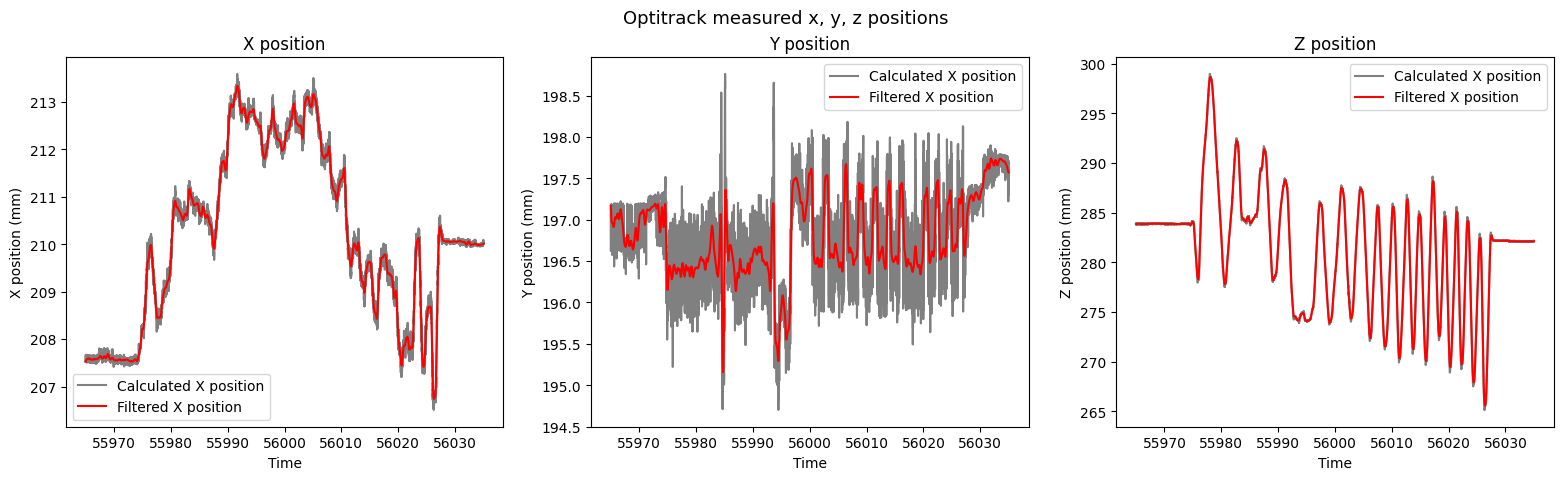

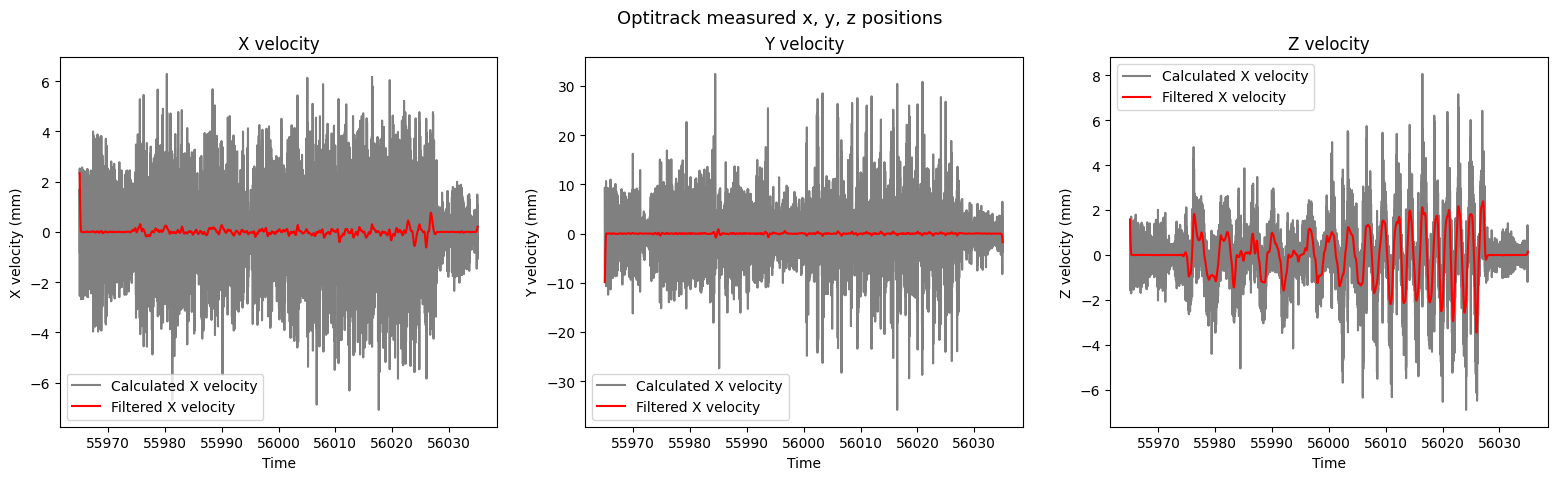

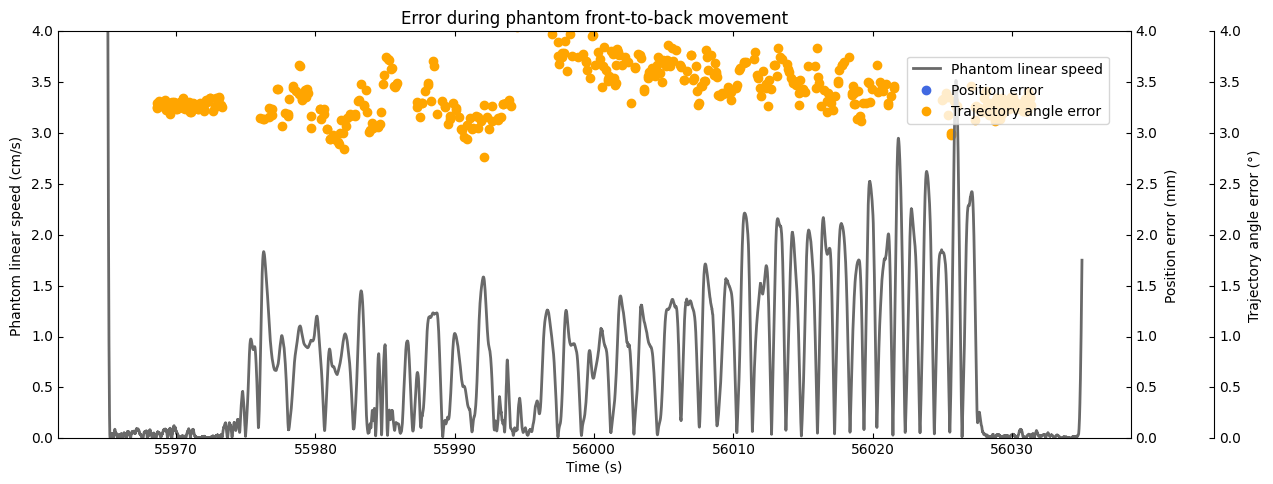

In [ ]:
# (1) Store Optirack measured x,y,z positions of the head
xPosOpti = []
yPosOpti = []
zPosOpti = []
for t in range(len(opt_time)):
  xPosOpti.append(headWrtOpti_xyz[t][0])
  yPosOpti.append(headWrtOpti_xyz[t][1])
  zPosOpti.append(headWrtOpti_xyz[t][2])
L= 45 #L-point filter; 45 points = 0.25 seconds
b = (np.ones(L))/L #numerator co-effs of filter transfer function
a = np.ones(1)  #denominator co-effs of filter transfer function
xPosOptiFiltered = signal.filtfilt(b,a,xPosOpti) #filter output using filtfilt function
yPosOptiFiltered = signal.filtfilt(b,a,yPosOpti)
zPosOptiFiltered = signal.filtfilt(b,a,zPosOpti)
# Plot calculted and filtered positions
fig,ax = plt.subplots(1,3,figsize=(19.2, 4.8))
fig.suptitle('Optitrack measured x, y, z positions',fontsize=13)
ax[0].plot(opt_time,xPosOpti, color = 'grey',label = "Calculated X position")
ax[0].plot(opt_time,xPosOptiFiltered, color = 'red',label = "Filtered X position")
ax[1].plot(opt_time,yPosOpti, color = 'grey',label = "Calculated X position")
ax[1].plot(opt_time,yPosOptiFiltered, color = 'red',label = "Filtered X position")
ax[2].plot(opt_time,zPosOpti, color = 'grey',label = "Calculated X position")
ax[2].plot(opt_time,zPosOptiFiltered, color = 'red',label = "Filtered X position")
ax[0].set(title = 'X position',xlabel = 'Time',ylabel='X position (mm)')
ax[0].legend()
ax[1].set(title = 'Y position',xlabel = 'Time',ylabel='Y position (mm)')
ax[1].legend()
ax[2].set(title = 'Z position',xlabel = 'Time',ylabel='Z position (mm)')
ax[2].legend()
# (2) Compute phantom linear speed given filtered position data
xVel, yVel, zVel = [],[],[]
for t in range(1,len(opt_time)):
  dt = opt_time[t]-opt_time[t-1]
  xVel.append((xPosOpti[t]-xPosOpti[t-1])/dt*1/10) # *1/10 converts to cm/s
  yVel.append((yPosOpti[t]-yPosOpti[t-1])/dt*1/10)
  zVel.append((zPosOpti[t]-zPosOpti[t-1])/dt*1/10)
xVelFiltered = signal.filtfilt(b,a,xVel) #filter output using filtfilt function
yVelFiltered = signal.filtfilt(b,a,yVel)
zVelFiltered = signal.filtfilt(b,a,zVel)
# Plot calculted and filtered velocities
fig,ax = plt.subplots(1,3,figsize=(19.2, 4.8))
fig.suptitle('Optitrack measured x, y, z positions',fontsize=13)
ax[0].plot(opt_time[1:],xVel, color = 'grey',label = "Calculated X velocity")
ax[0].plot(opt_time[1:],xVelFiltered, color = 'red',label = "Filtered X velocity")
ax[1].plot(opt_time[1:],yVel, color = 'grey',label = "Calculated X velocity")
ax[1].plot(opt_time[1:],yVelFiltered, color = 'red',label = "Filtered X velocity")
ax[2].plot(opt_time[1:],zVel, color = 'grey',label = "Calculated X velocity")
ax[2].plot(opt_time[1:],zVelFiltered, color = 'red',label = "Filtered X velocity")
ax[0].set(title = 'X velocity',xlabel = 'Time',ylabel='X velocity (mm)')
ax[0].legend()
ax[1].set(title = 'Y velocity',xlabel = 'Time',ylabel='Y velocity (mm)')
ax[1].legend()
ax[2].set(title = 'Z velocity',xlabel = 'Time',ylabel='Z velocity (mm)')
ax[2].legend()
# (3) Plot Zeta errors and phantom speed across time
headSpeedOptiFiltered = []
for t in range(len(xVelFiltered)):
  vel_norm = np.array([xVelFiltered[t],yVelFiltered[t],zVelFiltered[t]])
  headSpeedOptiFiltered.append(np.linalg.norm(vel_norm))
# Plot |Filtered linear velocity| vs Time; Position error vs Time; Trajectory angle error vs Time
fig = plt.figure(figsize=(12.4,4.8))
host = host_subplot(111, axes_class=axisartist.Axes)
par1 = host.twinx()
par2 = host.twinx()
par2.axis["right"] = par2.new_fixed_axis(loc="right", offset=(60, 0))
par1.axis["right"].toggle(all=True)
par2.axis["right"].toggle(all=True)
host.plot(opt_time[1:],headSpeedOptiFiltered,lw = 2,color="dimgray", label = "Phantom linear speed")
par1.scatter(zeta_time,positionErrors,color = "royalblue", label = "Position error")
par2.scatter(zeta_time,angleErrors,color = "orange", label = "Trajectory angle error")
host.set(ylim = (0,4),title = "Error during phantom front-to-back movement", xlabel="Time (s)", ylabel="Phantom linear speed (cm/s)")
par1.set(ylim=(0,4),ylabel = "Position error (mm)")
par2.set(ylim=(0,4),ylabel = "Trajectory angle error (°)")
lgd = fig.legend(bbox_to_anchor=(0.8,0.8), loc = "center",facecolor='white')
plt.tight_layout()

##### Compute phantom speed for each Zeta snapshot

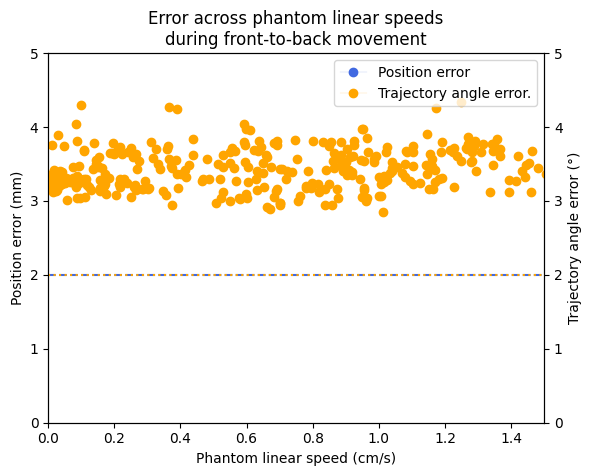

In [ ]:
# Compute phantom speed for each Zeta snapshot
# Calculate phantom velocity for every Zeta snapshot
f_interpolate = interp1d(opt_time[1:], headSpeedOptiFiltered)
zeta_vel = f_interpolate(zeta_time)
# Plot Position error and Trajectory angle error vs translational velocity
fig,ax = plt.subplots()
ax2 = ax.twinx()
ax.scatter(zeta_vel,positionErrors, color = "royalblue",label='Position error')
ax.axhline(y = 2, linestyle = '--',color='royalblue')
ax.set(title = "Error across phantom linear speeds\nduring front-to-back movement",ylim=(0,5),xlim=(0,1.5), xlabel="Phantom linear speed (cm/s)", ylabel="Position error (mm)")
# Plot Trajectory Angle error v. Time
ax2.scatter(zeta_vel,angleErrors, color = "orange",label='Trajectory angle error')
ax2.axhline(y = 2, linestyle = 'dotted',color = 'orange')
ax2.set(ylabel="Trajectory angle error (°)",ylim=(0,5))
err_markers = [Line2D([], [], color="royalblue", marker = "o",lw=0.1),
               Line2D([], [], color="orange", marker = "o",lw=0.1)]
lgd = ax2.legend(err_markers, ['Position error','Trajectory angle error.'],bbox_to_anchor=(1.0, 1.0),loc="upper right")

##### Compute phantom speed for each Zeta snapshot

/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


,Velocity,Avg.,Std.,"99% CI, Lower bound","99% CI, Upper bound",Samples
21,0.002415,11.007172,1.064861,10.829001,11.185343,237
462,0.003111,11.009167,1.066673,10.830315,11.188018,236
59,0.003659,11.008338,1.068864,10.828738,11.187938,235
480,0.003660,11.010608,1.070580,10.830337,11.190880,234
62,0.004044,11.010756,1.072872,10.829710,11.191801,233
...,...,...,...,...,...,...
428,2.398977,11.666118,0.265786,11.182019,12.150217,2
401,2.520902,11.400332,0.000000,NaN,NaN,1
421,2.874740,11.529576,0.000000,NaN,NaN,1
423,3.462776,12.803732,0.134853,12.558112,13.049352,2


The max. velocity with min. 20 samples, is 1.8183484811639823 
Index: 350
Max speed: 0.002415016508228516


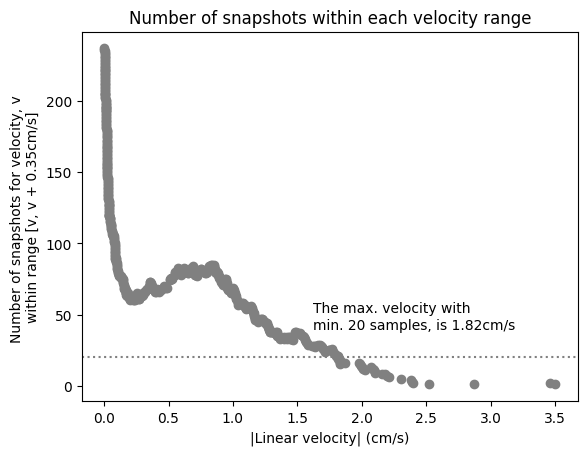

In [ ]:
# Compute average,std., and 99% CI of error for each velocity range [v, v+3.5 mm/s]
velocities = [abs(ele) for ele in zeta_vel]
posErrRange_avg,posErrRange_std,posErrRange_ci_L,posErrRange_ci_U = [],[],[],[]
n_samples = []
angErrRange_avg,angErrRange_std,angErrRange_ci_L,angErrRange_ci_U = [],[],[],[]
for v in velocities:
  v_posErrs = []
  v_angErrors = []
  count = 0
  for v2 in range(len(velocities)):
    if v <= velocities[v2] <= v + 0.35:
      v_posErrs.append(positionErrors[0][v2])
      v_angErrors.append(angleErrors[0][v2])
      count += 1
  posErrRange_avg.append(np.mean(v_posErrs))
  posErrRange_std.append(np.std(v_posErrs))
  ci_lower,ci_upper = stats.norm.interval(0.99, loc=np.mean(v_posErrs), scale=np.std(v_posErrs)/math.sqrt(len(v_posErrs)))
  posErrRange_ci_L.append(ci_lower)
  posErrRange_ci_U.append(ci_upper)
  n_samples.append(count)
  angErrRange_avg.append(np.mean(v_angErrors))
  angErrRange_std.append(np.std(v_angErrors))
  ci_low_ang,ci_up_ang = stats.norm.interval(0.99, loc=np.mean(v_angErrors), scale=np.std(v_angErrors)/math.sqrt(len(v_angErrors)))
  angErrRange_ci_L.append(ci_low_ang)
  angErrRange_ci_U.append(ci_up_ang)
# Determine when the number of samples for each range is < 20 samples
pos_ranges = {'Velocity': velocities,'Avg.': posErrRange_avg,'Std.':posErrRange_std, '99% CI, Lower bound': posErrRange_ci_L,'99% CI, Upper bound': posErrRange_ci_U, 'Samples': n_samples}
df_pos_ranges = pd.DataFrame(pos_ranges)
df_pos_ranges = df_pos_ranges.sort_values(by=['Velocity'])
ang_ranges = {'Velocity': velocities,'Avg.': angErrRange_avg,'Std.':angErrRange_std, '99% CI, Lower bound': angErrRange_ci_L,'99% CI, Upper bound': angErrRange_ci_U, 'Samples': n_samples}
df_ang_ranges = pd.DataFrame(ang_ranges)
df_ang_ranges = df_ang_ranges.sort_values(by=['Velocity'])
for max_index, row in df_pos_ranges.iterrows():
    if row['Samples'] < 20:
        velocity_below_20 = row['Velocity']
        break

display(df_pos_ranges)

# Plot number of samples in each velocity range
fig,ax = plt.subplots()
ax.scatter(velocities, n_samples,color='grey')
plt.axhline(y=20,color='grey',linestyle='dotted')
ax.set(title = 'Number of snapshots within each velocity range',xlabel='|Linear velocity| (cm/s)',ylabel='Number of snapshots for velocity, v \nwithin range [v, v + 0.35cm/s]')
plt.text(velocity_below_20-0.2,40,f'The max. velocity with\nmin. 20 samples, is {velocity_below_20:.2f}cm/s')
print('The max. velocity with min. 20 samples, is',velocity_below_20,'\nIndex:',max_index)

# Plot position and angle error across phantom linear velocities
# Determine maximum speed, where upper bound of 99% CI on position error crosses 2mm threshold
sorted_vel =  list(df_pos_ranges['Velocity'])
sorted_pos_avg = list(df_pos_ranges['Avg.'])
sorted_pos_std = list(df_pos_ranges['Std.'])
sorted_pos_ciL = list(df_pos_ranges['99% CI, Lower bound'])
sorted_pos_ciU = list(df_pos_ranges['99% CI, Upper bound'])
sorted_pos_stdL = [avg_error - std_dev for avg_error, std_dev in zip(sorted_pos_avg, sorted_pos_std)]
sorted_pos_stdU = [avg_error + std_dev for avg_error, std_dev in zip(sorted_pos_avg, sorted_pos_std)]
sorted_ang_avg = list(df_ang_ranges['Avg.'])
sorted_ang_std = list(df_ang_ranges['Std.'])
sorted_ang_ciL = list(df_ang_ranges['99% CI, Lower bound'])
sorted_ang_ciU = list(df_ang_ranges['99% CI, Upper bound'])
sorted_ang_stdL = [avg_error - std_dev for avg_error, std_dev in zip(sorted_ang_avg, sorted_ang_std)]
sorted_ang_stdU = [avg_error + std_dev for avg_error, std_dev in zip(sorted_ang_avg, sorted_ang_std)]
max_speed = 0
for e in range(len(sorted_pos_ciU)):
  if (sorted_pos_ciU[e]) >= 2:
    max_speed += sorted_vel[e]
    break
print('Max speed:',max_speed)

The maximum phantom linear speed (cm/s) is: 0.002415016508228516


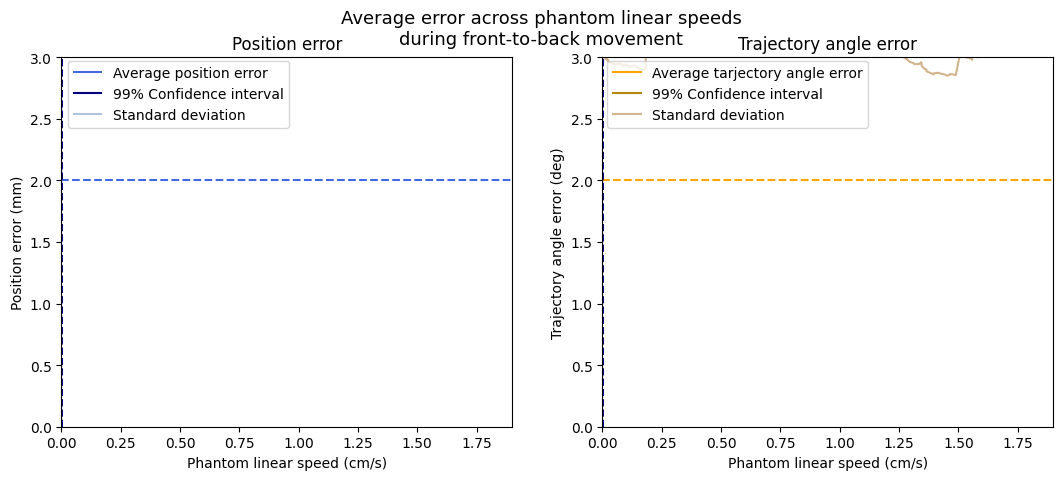

In [ ]:
# Plot results for position error
fig,ax = plt.subplots(1,2,figsize=(12.8, 4.8))
fig.suptitle('Average error across phantom linear speeds\nduring front-to-back movement',fontsize=13)
ax[0].plot(sorted_vel,sorted_pos_avg, color = 'royalblue',label = "Average position error")
ax[0].set(title = 'Position error',xlabel = 'Phantom linear speed (cm/s)',xlim = (0,1.9),ylabel='Position error (mm)',ylim = (0,3))
ax[0].axhline(y=2,linestyle = '--',color='royalblue')
ax[0].plot(sorted_vel,sorted_pos_ciL,color = 'navy',label = '99% Confidence interval')
ax[0].plot(sorted_vel,sorted_pos_ciU,color = 'navy')
ax[0].plot(sorted_vel,sorted_pos_stdL,color='lightsteelblue',label = 'Standard deviation')
ax[0].plot(sorted_vel,sorted_pos_stdU,color='lightsteelblue')
ax[0].legend(bbox_to_anchor=(0.26,0.9),loc="center")
ax[0].axvline(x=max_speed,linestyle = '--',color='navy',lw=1.4)
# Plot results for trajectory angle error
ax[1].plot(sorted_vel,sorted_ang_avg, color = 'orange',label = "Average tarjectory angle error")
ax[1].set(title = 'Trajectory angle error',xlabel = 'Phantom linear speed (cm/s)',xlim = (0,1.9),ylabel='Trajectory angle error (deg)',ylim = (0,3))
ax[1].axhline(y=2,linestyle = '--',color='orange')
ax[1].plot(sorted_vel,sorted_ang_ciL,color = 'darkgoldenrod',label = '99% Confidence interval')
ax[1].plot(sorted_vel,sorted_ang_ciU,color = 'darkgoldenrod')
ax[1].plot(sorted_vel,sorted_ang_stdL,color='tan',label = 'Standard deviation')
ax[1].plot(sorted_vel,sorted_ang_stdU,color='tan')
ax[1].legend(bbox_to_anchor=(0.3,0.9),loc="center")
ax[1].axvline(x=max_speed,linestyle = '--',color='navy',lw=1.4)

print("The maximum phantom linear speed (cm/s) is:",max_speed)

### 6. Latency Testing
Computes registration and instrument tracking latenct

**Instructions**:

1.   Modify the following variables to match the corresponding Zeta and  Optitrack files: `zeta_file`,  `opti_file`
2. Review plots and save results (you may adjust the edge values that are cut off from Zeta data in lines 4-6 of the cell below)

In [ ]:
zeta_file = "SR_latency NEW.txt"
opti_file = "SR_latency NEW.csv"
# Import Zeta and Optitrack files
toolWrtCt, toolWrtCam, ctWrtCam, zeta_time, zeta_sre, toolWrtCt_xyz = open_Zeta(zeta_file)
toolWrtOpti, headWrtOpti, toolWrtOpti_xyz, headWrtOpti_xyz, opt_time, opt_orig_time = open_Motive_dynamic(opti_file)
zeta_time = zeta_time[25:-30] # Cut off edge values from Zeta data
ctWrtCam = ctWrtCam[25:-30]
toolWrtCam = toolWrtCam[25:-30]
# Determine indeces to align Zeta and Optitrack start/end times
print("Zeta start time:", zeta_time[0])
opti_start_indx = 0
for t in range(len(opt_time)):
  if opt_time[t] >= zeta_time[0]:
    opti_start_indx = t
    break
print("Optitrack start time:", opt_time[opti_start_indx])
print("Zeta end time:", zeta_time[-1])
opti_end_indx = 0
for t in range(len(opt_time)):
  if opt_time[t] >= zeta_time[-1]:
    opti_end_indx = t
    break
print("Optitrack end time:", opt_time[opti_end_indx])
# Modify data to match determined indexes
opt_time = opt_time[opti_start_indx:opti_end_indx+1] # Cut off Optitrack values to end at same time as Zeta
headWrtOpti = headWrtOpti[opti_start_indx:opti_end_indx+1]
toolWrtOpti = toolWrtOpti[opti_start_indx:opti_end_indx+1]
print(opt_time)

Zeta start time: 55539.979
Optitrack start time: 55539.980111000004
Zeta end time: 55593.058
Optitrack end time: 55593.063444
[55539.980111000004, 55539.985667, 55539.991222000004, 55539.996778, 55540.002333000004, 55540.007889, 55540.013444000004, 55540.019, 55540.024556000004, 55540.030111, 55540.035667000004, 55540.041222, 55540.046778, 55540.052333, 55540.057889, 55540.063444, 55540.069, 55540.074556, 55540.080111, 55540.085667, 55540.091222, 55540.096778, 55540.102333, 55540.107889, 55540.113444, 55540.119, 55540.124556, 55540.130111, 55540.135667, 55540.141222, 55540.146778, 55540.152333, 55540.157889, 55540.163444000005, 55540.169, 55540.174556, 55540.180111, 55540.185667000005, 55540.191222, 55540.196778000005, 55540.202333, 55540.207889000005, 55540.213444, 55540.219000000005, 55540.224556, 55540.230111000004, 55540.235667, 55540.241222000004, 55540.246778, 55540.252333000004, 55540.257889, 55540.263444000004, 55540.269, 55540.274556000004, 55540.280111, 55540.285667000004, 55

Registration Latency: 0.0
Tracking Latency: 0.0
Computed registration latency (s): 
0.0

Computed instrument tracking latency (s): 
0.0


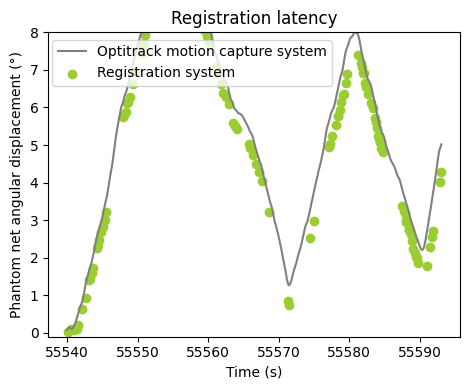

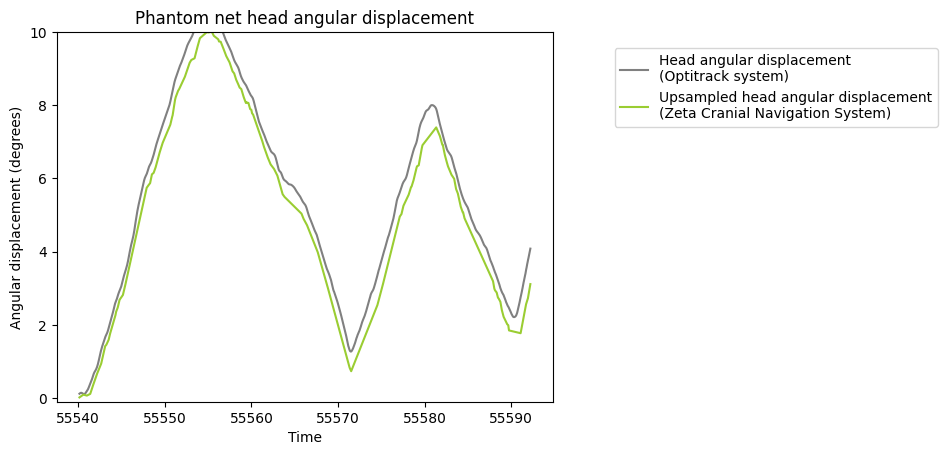

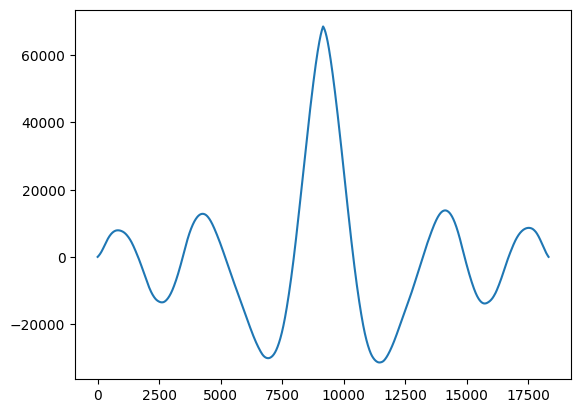

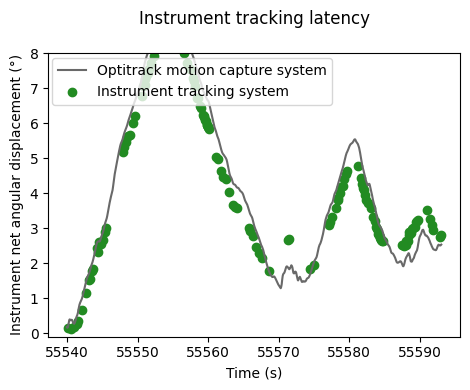

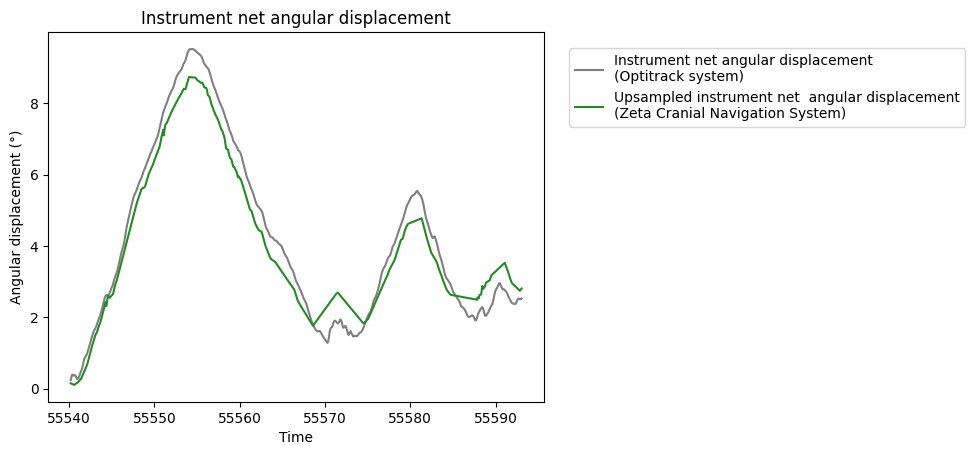

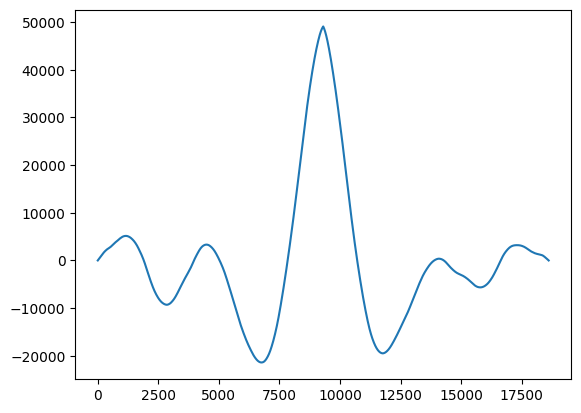

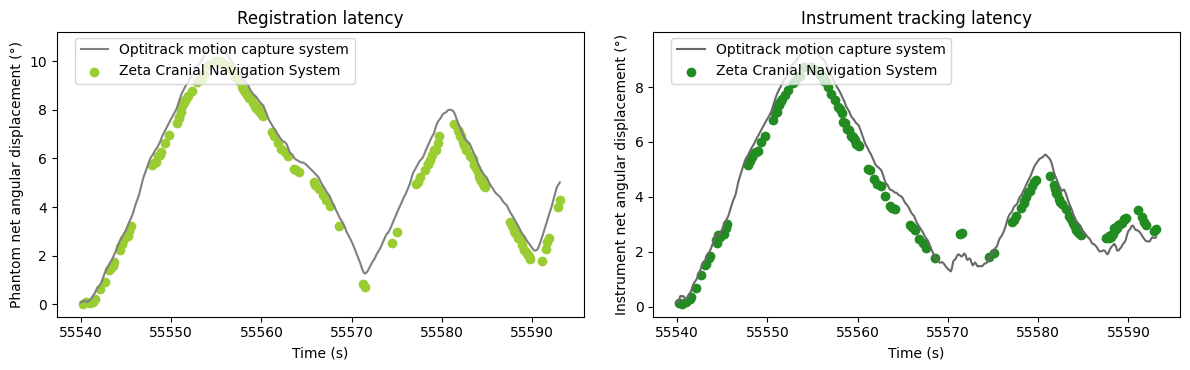

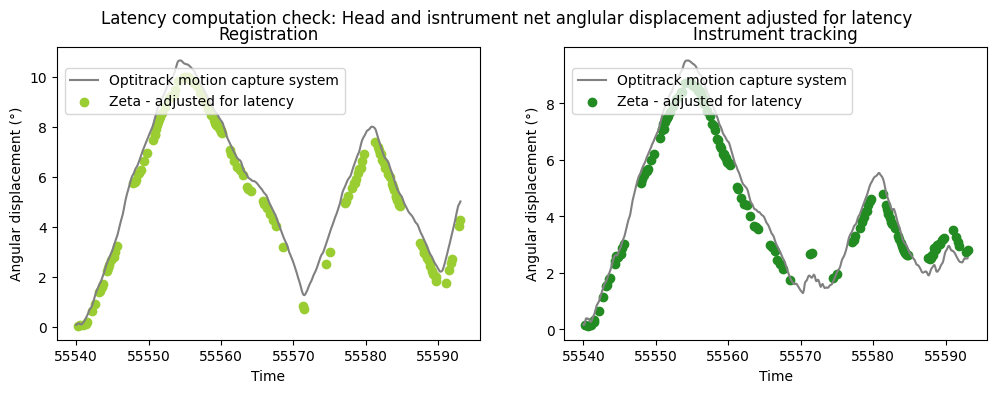

In [ ]:
# Registration latency
# (1) Measure head angular displacement as measured by Zeta and Optitrack
# Optitrack
headWrtOpti_rot = [] # Store head rotation matrices
for q in headWrtOpti:
  m_qt = np.quaternion(q[3],q[0],q[1],q[2])
  m_rotM = quaternion.as_rotation_matrix(m_qt)
  headWrtOpti_rot.append(m_rotM)
# Store angular displacement from t=0 for every timestamp
headWrtOpti_angDisp = []
for i in range(1,len(headWrtOpti_rot)):
  R1 = headWrtOpti_rot[0]
  R2 = headWrtOpti_rot[i]
  angle = np.arccos((np.trace(np.matmul(R1.T, R2)) - 1) / 2) # Convert difference of rotation matrices to angle (radians)
  headWrtOpti_angDisp.append(np.degrees(angle))
# Filter Optitrack data
L= 45 #L-point filter; 45 points = 0.25 seconds
b = (np.ones(L))/L #numerator co-effs of filter transfer function
a = np.ones(1)  #denominator co-effs of filter transfer function
headWrtOpti_angDisp = signal.filtfilt(b,a,headWrtOpti_angDisp) #filter output using filtfilt function
# Zeta
ctWrtCam_angDisp = []
for i in range(1,len(zeta_time)):
  R1_q = R.from_matrix(ctWrtCam[0][0][:3,:3]).as_quat()
  R2_q = R.from_matrix(ctWrtCam[i][0][:3,:3]).as_quat()
  R1 = R.from_quat(R1_q).as_matrix()
  R2 = R.from_quat(R2_q).as_matrix()
  angle = np.arccos((np.trace(np.matmul(R1.T, R2)) - 1) / 2) # Convert difference of rotation matrices to angle (radians)
  ctWrtCam_angDisp.append(np.degrees(angle))
# Plot results vs. Time
fig,ax = plt.subplots(figsize=(4.8,4))
ax.plot(opt_time[1:],headWrtOpti_angDisp,label = "Optitrack motion capture system",color="grey")
ax.scatter(zeta_time[1:],ctWrtCam_angDisp,label="Registration system",color="yellowgreen")
ax.set(title="Registration latency",xlabel="Time (s)",ylabel="Phantom net angular displacement (°)",ylim=(-0.1,8))
ax.legend(bbox_to_anchor=(0.35,0.9),loc="center")
fig.tight_layout()
# (2) Compute cross-correlation latency
# Upsasmple Zeta to match Optitrack's sampling frequency
f_upsample = interpolate.interp1d(zeta_time[1:],ctWrtCam_angDisp,kind='linear', fill_value="extrapolate")
upsampled_ctWrtCam_angDisp = f_upsample(opt_time[30:-150])
# Plot upsampled Zeta values vs. Time
headWrtOpti_angDisp_trunc = headWrtOpti_angDisp[30:-149]
fig,ax = plt.subplots()
ax.plot(opt_time[30:-150],headWrtOpti_angDisp_trunc,label = "Head angular displacement\n(Optitrack system)",color="grey")
ax.plot(opt_time[30:-150],upsampled_ctWrtCam_angDisp,label="Upsampled head angular displacement\n(Zeta Cranial Navigation System)",color="yellowgreen")
ax.set(title="Phantom net head angular displacement",xlabel="Time",ylabel="Angular displacement (degrees)",ylim=(-0.1,10))
ax.legend(bbox_to_anchor=(1.45,0.85),loc="center")
# Compute cross-correlation between the two sets of data (same sized)
corr = np.correlate(upsampled_ctWrtCam_angDisp - np.mean(upsampled_ctWrtCam_angDisp),
                    headWrtOpti_angDisp_trunc - np.mean(headWrtOpti_angDisp_trunc),
                    mode='full')
fig = plt.figure()
plt.plot(corr)
# Compute latency
lag = corr.argmax() - (len(upsampled_ctWrtCam_angDisp) - 1)
latency_reg = lag/180
print("Registration Latency:", latency_reg)

# Instrument tracking latency
# (1) Measure instrument angular displacement as measured by Zeta and Optitrack
# Optitrack
toolWrtOpti_rot = []
for q in toolWrtOpti:
  m_qt = np.quaternion(q[3],q[0],q[1],q[2])
  m_rotM = quaternion.as_rotation_matrix(m_qt)
  toolWrtOpti_rot.append(m_rotM)
# Store angular displacement from t=0 for every timestamp
toolWrtOpti_angDisp = []
for i in range(1,len(headWrtOpti_rot)):
  R1 = toolWrtOpti_rot[0]
  R2 = toolWrtOpti_rot[i]
  angle = np.arccos((np.trace(np.matmul(R1.T, R2)) - 1) / 2) # Convert difference of rotation matrices to angle (radians)
  toolWrtOpti_angDisp.append(np.degrees(angle))
# Filter Optitrack data
L= 45 #L-point filter; 45 points = 0.25 seconds
b = (np.ones(L))/L #numerator co-effs of filter transfer function
a = np.ones(1)  #denominator co-effs of filter transfer function
toolWrtOpti_angDisp = signal.filtfilt(b,a,toolWrtOpti_angDisp) #filter output using filtfilt function
# Zeta
toolWrtCam_angDisp = []
for i in range(1,len(zeta_time)):
  R1_q = R.from_matrix(toolWrtCam[0][0][:3,:3]).as_quat()
  R2_q = R.from_matrix(toolWrtCam[i][0][:3,:3]).as_quat()
  R1 = R.from_quat(R1_q).as_matrix()
  R2 = R.from_quat(R2_q).as_matrix()
  angle = np.arccos((np.trace(np.matmul(R1.T, R2)) - 1) / 2) # Convert difference of rotation matrices to angle (radians)
  toolWrtCam_angDisp.append(np.degrees(angle))
# Plot results vs. Time
fig,ax = plt.subplots(figsize=(4.8,4))
ax.plot(opt_time[1:],toolWrtOpti_angDisp,label = "Optitrack motion capture system",color="dimgrey")
ax.scatter(zeta_time[1:],toolWrtCam_angDisp,label="Instrument tracking system",color="forestgreen")
ax.set(title="Instrument tracking latency\n",xlabel="Time (s)",ylabel="Instrument net angular displacement (°)",ylim=(-0.1,8))
ax.legend(bbox_to_anchor=(0.35,0.9),loc="center")
fig.tight_layout()
# (2) Compute cross-correlation latency
# Upsasmple Zeta to match Optitrack's sampling frequency
f_upsample = interpolate.interp1d(zeta_time[1:],toolWrtCam_angDisp,kind='linear', fill_value="extrapolate")
upsampled_toolWrtCam_angDisp = f_upsample(opt_time[38:-3])
# Plot upsampled Zeta values vs. Time
toolWrtOpti_angDisp_trunc = toolWrtOpti_angDisp[38:-2]
fig,ax = plt.subplots()
ax.plot(opt_time[38:-3],toolWrtOpti_angDisp_trunc,label = "Instrument net angular displacement\n(Optitrack system)",color="grey")
ax.plot(opt_time[38:-3],upsampled_toolWrtCam_angDisp,label="Upsampled instrument net  angular displacement\n(Zeta Cranial Navigation System)",color="forestgreen")
ax.set(title="Instrument net angular displacement",xlabel="Time",ylabel="Angular displacement (°)")#,xlim=(zeta_time[0]-1,zeta_time[-1]+1))
ax.legend(bbox_to_anchor=(1.45,0.85),loc="center")
# Calculate cross-correlation and compute latency
corr = np.correlate(upsampled_toolWrtCam_angDisp - np.mean(upsampled_toolWrtCam_angDisp),
                    toolWrtOpti_angDisp_trunc - np.mean(toolWrtOpti_angDisp_trunc),
                    mode='full')
fig = plt.figure()
plt.plot(corr)
# Compute latency
lag = corr.argmax() - (len(upsampled_toolWrtCam_angDisp) - 1)
latency_track = lag/180
print("Tracking Latency:", latency_track)

# Store latency plots
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 3.8))
ax1.plot(opt_time[1:],headWrtOpti_angDisp,label = "Optitrack motion capture system",color="grey")
ax1.scatter(zeta_time[1:],ctWrtCam_angDisp,label="Zeta Cranial Navigation System",color="yellowgreen")
ax1.set(title="Registration latency",xlabel="Time (s)",ylabel="Phantom net angular displacement (°)")
ax1.legend(bbox_to_anchor=(0.3,0.9),loc="center")
ax2.plot(opt_time[1:],toolWrtOpti_angDisp,label = "Optitrack motion capture system",color="dimgrey")
ax2.scatter(zeta_time[1:],toolWrtCam_angDisp,label="Zeta Cranial Navigation System",color="forestgreen")
ax2.set(title="Instrument tracking latency",xlabel="Time (s)",ylabel="\nInstrument net angular displacement (°)")
ax2.legend(bbox_to_anchor=(0.3,0.9),loc="center")
fig.tight_layout()

# Apply latency to data as a check that Zeta data aligns with Optitrack data and store plot
adjusted_zeta_time_reg = [ x - latency_reg for x in zeta_time]
adjusted_zeta_time_track = [ x - latency_track for x in zeta_time]
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 3.8))
fig.suptitle('Latency computation check: Head and isntrument net anglular displacement adjusted for latency')
ax1.plot(opt_time[1:],headWrtOpti_angDisp,label = "Optitrack motion capture system",color="grey")
ax1.scatter(adjusted_zeta_time_reg[1:],ctWrtCam_angDisp,label="Zeta - adjusted for latency",color="yellowgreen")
ax1.set(title="Registration",xlabel="Time",ylabel="Angular displacement (°)")
ax1.legend(bbox_to_anchor=(0.35,0.85),loc="center")
ax2.plot(opt_time[1:],toolWrtOpti_angDisp,label = "Optitrack motion capture system",color="grey")
ax2.scatter(adjusted_zeta_time_track[1:],toolWrtCam_angDisp,label="Zeta - adjusted for latency",color="forestgreen")
ax2.set(title="Instrument tracking",xlabel="Time",ylabel="Angular displacement (°)")
ax2.legend(bbox_to_anchor=(0.35,0.85),loc="center")

# Print latency results
print(f"Computed registration latency (s): \n{latency_reg}")
print(f"\nComputed instrument tracking latency (s): \n{latency_track}")